<a href="https://colab.research.google.com/github/dinaglamshowroom/projet-data_oc/blob/main/projet_4_Analyse_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analyse des ventes d’une librairie
Après avoir procédé au nettoyage et à la préparation des données dans la première partie du projet, nous allons désormais nous concentrer sur l’analyse des ventes de l’entreprise. Cette étape a pour objectif de dégager les principaux indicateurs de performance (CA, volume, panier moyen), d’identifier les profils clients les plus contributifs, ainsi que de mettre en évidence les tendances et disparités selon les catégories de produits, l’âge ou le sexe des acheteurs. L’analyse vise ainsi à fournir une vision claire et structurée de l’activité commerciale, étape préalable à la formulation de recommandations stratégiques.





>








## 1. Chargement et fusion des données

 Thème Nature Pastel activé.


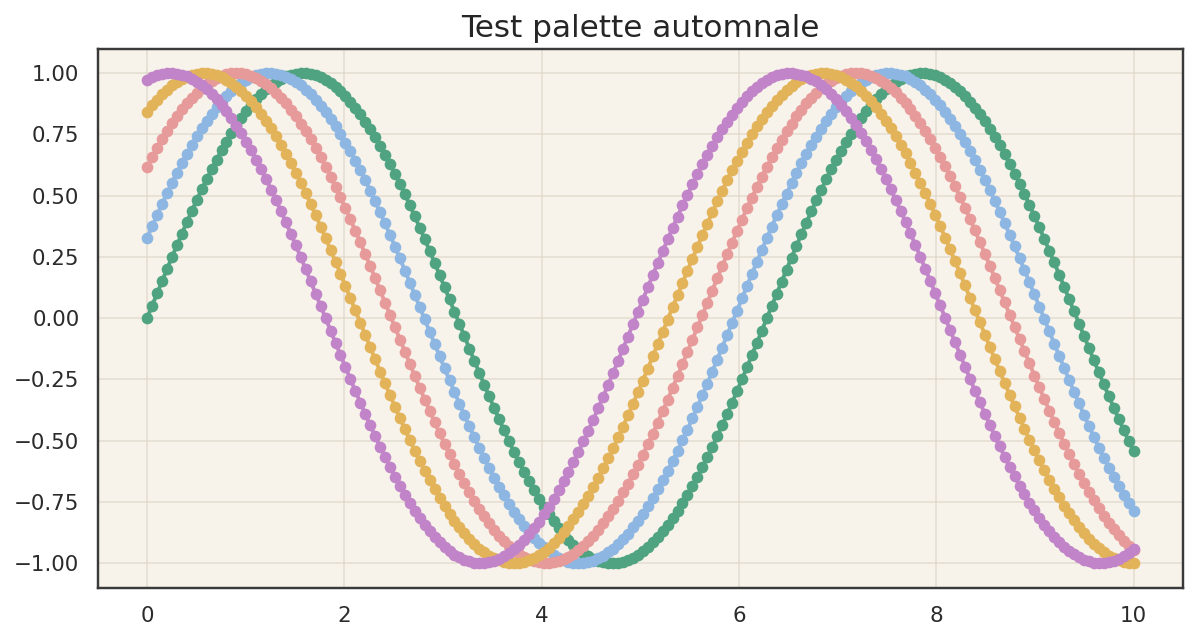

In [355]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.pylab as pylab
from matplotlib import cycler
import re


PALETTE = NATURE_PASTEL_PRIMARY_6 = [
    "#4FA380",  # vert sapin doux (nature)
    "#8DB6E2",  # bleu ciel pastel
    "#E79A9A",  # rouge pastel (corail doux)  ← remplace le 2e vert
    "#E3B35A",  # orge/bois clair
    "#C184C8",  # lilas/bruyère
    "#C9A27E",  # terre/argile pastel
]


# Seaborn
sns.set_theme(context="notebook", style="whitegrid", palette=PALETTE)

# Matplotlib (thème Nature Pastel)

plt.rcParams.update({

   # Dimensions / résolution
    "figure.figsize": (10, 5),
    "figure.dpi": 140,

    # Typo & axes
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,

    # Fond et grille (beige doux pour votre charte)
    "axes.facecolor": "#F7F3EA",   # beige pastel (très clair)
    "figure.facecolor": "#FFFFFF",
    "grid.color": "#DCD3C5",       # grille subtile
    "grid.alpha": 0.55,
    "axes.edgecolor": "#3A3A3A",
    "axes.labelcolor": "#2B2B2B",
    "xtick.color": "#2B2B2B",
    "ytick.color": "#2B2B2B",
})

print(" Thème Nature Pastel activé.")



# Exemple de test : plusieurs courbes devraient avoir des couleurs automnales différentes
import numpy as np
x = np.linspace(0, 10, 200)
for i in range(5):
    plt.plot(x, np.sin(x + i/3), linewidth=2)
plt.title("Test palette automnale")
plt.show()



In [356]:
#autorisation d'acces au google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#importation des données depuis un ficher dans google drive
import os, glob

DATA_DIR = "/content/drive/MyDrive/Projet_P4/Data_p4_clean"
csv_files = glob.glob(os.path.join(DATA_DIR, "*.csv"))

print("Fichiers CSV trouvés :")
for f in csv_files:
    print(f)

# Charger tous les CSV dans un dictionnaire
import pandas as pd
dfs = {f.split("/")[-1]: pd.read_csv(f) for f in csv_files}

Mounted at /content/drive
Fichiers CSV trouvés :
/content/drive/MyDrive/Projet_P4/Data_p4_clean/transactions_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/products_clean.csv
/content/drive/MyDrive/Projet_P4/Data_p4_clean/customers_clean.csv


**Configuration Pandas**

In [357]:

# Afficher toutes les colonnes sans troncature
pd.set_option("display.max_columns", None)
# Limiter le nombre de lignes affichées
pd.set_option("display.max_rows", 100)
# Formater les floats pour plus de lisibilité
pd.set_option("display.float_format", lambda x: "%.2f" % x)

**Création de la table de fait df_tf**

##Création de la mega DataFrame (df_tf)

Sachant que:

* transactions = table de faits (chaque ligne = un achat)

* products = table de dimensions (prix, catégorie des produits)

* customers = table de dimensions (sexe, date de naissance des clients)

Nous allons créé une table de faits enrichie en joignant les 3 dataframes. On obtient alors une seule mega DataFrame (df_tf) qui contient :

* Grain : une ligne = une transaction.

* Mesures : prix, CA, volume.

* Dimensions : tout ce qui décrit la transaction (produit, catégorie, client, sexe, âge, date…).


In [358]:
#appeler et renommer les dataframes
df_customers= dfs["customers_clean.csv"]
df_products = dfs["products_clean.csv"]
df_transactions = dfs["transactions_clean.csv"]

In [359]:


# Assurer des chaînes propres (déjà fait, mais proprement pour éviter l’avertissement)
df_transactions.loc[:, "id_prod"] = df_transactions["id_prod"].astype(str).str.strip()
df_products.loc[:, "id_prod"] = df_products["id_prod"].astype(str).str.strip()

print("client_id unique dans customers ?", df_customers["client_id"].is_unique)
print("nid_prod est unique ?", df_products["id_prod"].is_unique)

# --- Doublons réels dans transactions ---
print("Doublons exacts de lignes transactions :", df_transactions.duplicated().sum())

# --- Doublons réels dans customers ---
print("Doublons exacts de lignes customers :", df_customers.duplicated().sum())

# --- Doublons réels dans products ---
print("Doublons exacts de lignes products :", df_products.duplicated().sum())

# Clients référencés dans transactions mais absents de customers (problème d'intégrité)
invalid_clients = set(df_transactions["client_id"]) - set(df_customers["client_id"])
print("Clients dans transactions mais pas dans customers :", len(invalid_clients))

# Produits référencés dans transactions mais absents de customers (problème d'intégrité)
invalid_products = set(df_transactions["id_prod"]) - set(df_products["id_prod"])
print("Produits dans transactions mais pas dans products :", len(invalid_products))

# Vérifier que des lignes entieres ne soient dupliquées
print("Doublons exacts de lignes transactions :", df_transactions.duplicated().sum())

df_customers = df_customers[(df_customers.client_id != 'ct_0') & (df_customers.client_id != 'ct_1')]

client_id unique dans customers ? True
nid_prod est unique ? True
Doublons exacts de lignes transactions : 0
Doublons exacts de lignes customers : 0
Doublons exacts de lignes products : 0
Clients dans transactions mais pas dans customers : 0
Produits dans transactions mais pas dans products : 0
Doublons exacts de lignes transactions : 0


In [360]:
# Conversion des dates
df_transactions["date"] = pd.to_datetime(df_transactions["date"], format="%Y-%m-%d %H:%M:%S.%f", errors="coerce")
df_transactions['month'] = df_transactions['date'].dt.to_period('M')
nb_nat = df_transactions["date"].isna().sum()
nb_nat

np.int64(0)

In [361]:
# Jointures de la "megadataframe" table de faits
df_tf = (
    df_transactions
      .merge(df_products,  on="id_prod",    how="left")
      .merge(df_customers, on="client_id",  how="left")
)
# On met au bon format
df_tf["date"]  = pd.to_datetime(df_tf["date"], errors="coerce")
df_tf["price"] = pd.to_numeric(df_tf["price"], errors="coerce")
df_tf["month"] = df_tf["date"].dt.to_period("M")
df_tf["categ"] = pd.to_numeric(df_tf["categ"], errors="coerce").astype("Int64")

df_tf.head()

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45


# Analyse des données

L’analyse suivra une démarche progressive, répondant aux exigences fixées :

**Exploration descriptive des données**

Présentation des principales variables disponibles (quantitatives et qualitatives).

Calcul d’indicateurs de tendance centrale et de dispersion (moyenne, médiane, écart-type, minimum, maximum).

**Analyse de la distribution des ventes**

  - Étude de la concentration du chiffre d’affaires par client et par produit.

  - Construction d’une courbe de Lorenz et calcul de l’indice de Gini pour mesurer l’inégalité de répartition des ventes.

**Visualisation des données**

  - Réalisation de représentations graphiques variées :

  - Histogrammes (ex. distribution des prix, des âges).

  - Boîtes à moustaches (boxplots) pour détecter valeurs extrêmes et comparer des groupes.

  - Séries temporelles (évolution des ventes dans le temps).


##Exploration descriptive des données

###KPIs globaux

In [362]:


# ======================
# 1. KPIs globaux
# ======================
print("=== KPIs GLOBAUX ===")
print("Nombre total de transactions :", len(df_tf))
print("Nombre de clients uniques :", df_tf["client_id"].nunique())
print("Nombre de produits distincts vendus :", df_tf["id_prod"].nunique())
print("CA total :", df_tf["price"].sum())

=== KPIs GLOBAUX ===
Nombre total de transactions : 336713
Nombre de clients uniques : 8600
Nombre de produits distincts vendus : 3264
CA total : 5796577.7700000005


In [363]:
# Produits vendus (ceux qui apparaissent dans au moins une session)
produits_vendus = set(df_tf.loc[df_tf["session_id"].notna(), "id_prod"].unique())

# Tous les produits (dans la table)
tous_produits = set(df_tf["id_prod"].unique())

# Produits jamais vendus
produits_non_vendus = tous_produits - produits_vendus

print(f"Nombre de produits jamais vendus : {len(produits_non_vendus)}")
print(f"Produits non vendus : {list(produits_non_vendus)[:10]}")

Nombre de produits jamais vendus : 0
Produits non vendus : []


In [364]:
# les prix strictement positifs
df_tf = df_tf[df_tf["price"] > 0]


Avec 336 713 transactions réalisées par 8 600 clients uniques, l'entreprise a généré un chiffre d'affaires total de 5,8 millions d'euros en vendant 3 264 produits distincts."

## 2. Statistiques descriptives du chiffre d’affaires

In [365]:
lower_bound = stats['25%'] - 1.5 * IQR
upper_bound = stats['75%'] + 1.5 * IQR
outliers = df_tf[(df_tf['price'] < lower_bound) | (df_tf['price'] > upper_bound)]
filtered_df = df_tf[(df_tf['price'] >= lower_bound) & (df_tf['price'] <= upper_bound)]
filtered_df.head(5)

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45
5,0_1085,2021-09-15 05:47:48.215162,s_90139,c_2526,2021-09,3.99,0,f,1982,43


In [366]:


# Fusion des tables
df = df_transactions.merge(df_products, on='id_prod', how='left')
df = df.merge(df_customers, on='client_id', how='left')
df

,id_prod,date,session_id,client_id,month,price,categ,sex,birth,age
0,0_1483,2021-04-10 18:37:28.723910,s_18746,c_4450,2021-04,4.99,0,f,1977,48
1,2_226,2022-02-03 01:55:53.276402,s_159142,c_277,2022-02,65.75,2,f,2000,25
2,1_374,2021-09-23 15:13:46.938559,s_94290,c_4270,2021-09,10.71,1,f,1979,46
3,0_2186,2021-10-17 03:27:18.783634,s_105936,c_4597,2021-10,4.20,0,m,1963,62
4,0_1351,2021-07-17 20:34:25.800563,s_63642,c_1242,2021-07,8.99,0,f,1980,45
...,...,...,...,...,...,...,...,...,...,...
336708,1_671,2021-05-28 12:35:46.214839,s_40720,c_3454,2021-05,31.99,1,m,1969,56
336709,0_759,2021-06-19 00:19:23.917703,s_50568,c_6268,2021-06,22.99,0,m,1991,34
336710,0_1256,2021-03-16 17:31:59.442007,s_7219,c_4137,2021-03,11.03,0,f,1968,57
336711,2_227,2021-10-30 16:50:15.997750,s_112349,c_5,2021-10,50.99,2,f,1994,31


In [367]:
# Statistiques de tendance centrale et dispersion
stats = df_tf['price'].describe()
IQR = stats['75%'] - stats['25%']
print(stats)
print(f'IQR : {IQR:.2f}')




count   336713.00
mean        17.22
std         17.86
min          0.62
25%          8.61
50%         13.90
75%         18.99
max        300.00
Name: price, dtype: float64
IQR : 10.38


* **Moyenne (17,22 €) et médiane (13,90 €)** sont proches mais pas identiques, ce qui confirme la présence d’une queue à droite (quelques valeurs élevées tirent la moyenne vers le haut).

* **L’IQR (10,38 €)** indique que la majorité des prix est concentrée dans une plage relativement restreinte (entre 8,61 € et 18,99 €).

* **La valeur maximale (300 €)** est plus de 17 fois supérieure à la médiane, ce qui traduit la présence de valeurs extrêmes peu fréquentes mais significatives.

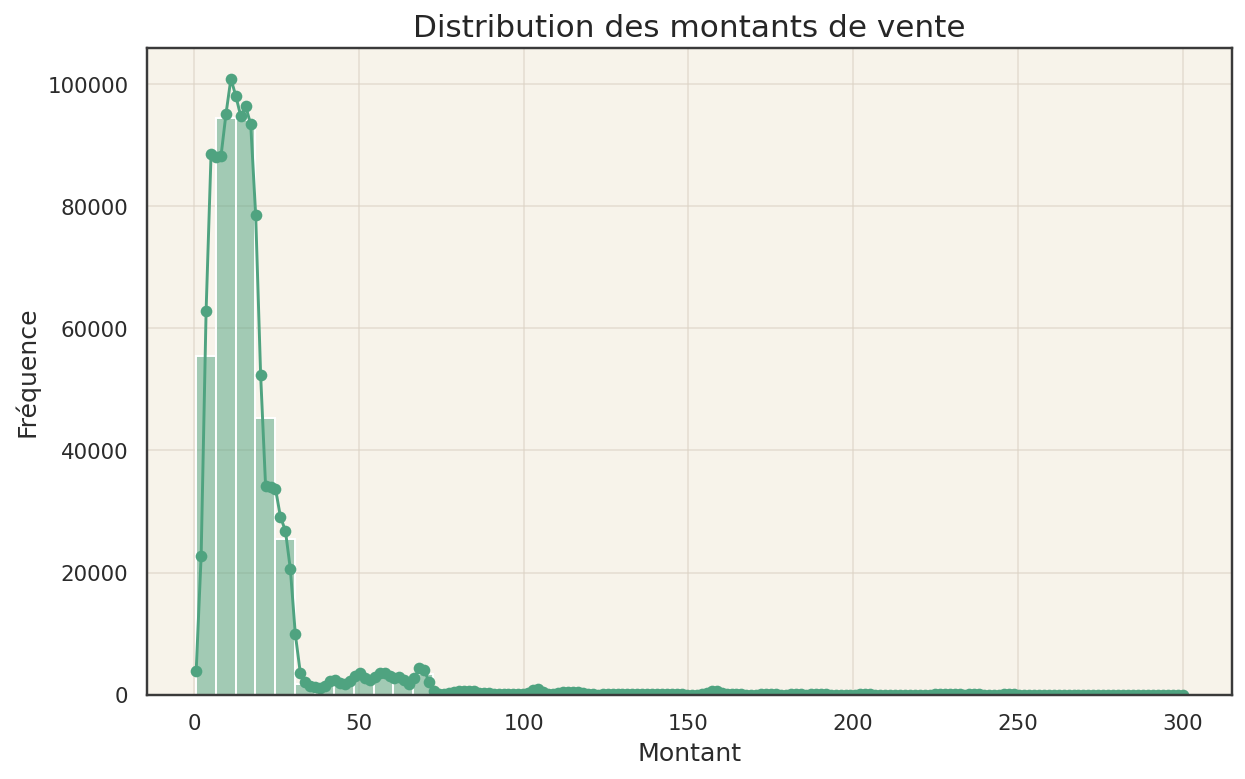

In [368]:
plt.figure(figsize=(10,6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution des montants de vente')
plt.xlabel('Montant')
plt.ylabel('Fréquence')
plt.show()

**Interprétation :**

**Deux comportements** d’achat se distinguent :

* **Clientèle majoritaire** : achats à petits montants mais très fréquents — ils représentent le cœur de la distribution.

* **Clientèle minoritaire** : achats plus rares mais plus onéreux, contribuant de manière disproportionnée au chiffre d’affaires global.


Le marché présente une **segmentation** naturelle entre acheteurs **“quotidiens”** et acheteurs **“premium”**.

Une part importante du CA est probablement concentrée sur une minorité de transactions, phénomène typique d’une distribution de type **loi de Pareto** (80-20).

Pour confirmer ce phénomène, nous allons compléter cette analyse par :

* une courbe de Lorenz,

* un indice de Gini,

* une analyse du CA par tranche de prix.

###Analyse temporelle ( par mois)

In [369]:
# Fenêtre temporelle
periode = pd.period_range("2021-03", "2022-02", freq="M")

# Agrégation CA par mois
ca_mensuel = (
    df_tf.groupby("month", observed=True)["price"]
         .sum()
    .reindex(periode, fill_value=0)       # complète les mois absents
)

# Passage en Timestamp pour le tracé / indexation temporelle
df_ca_mensuel = ca_mensuel.copy()
df_ca_mensuel.index = df_ca_mensuel.index.to_timestamp()  # 2021-10 → 2021-10-01 00:00:00

print(df_ca_mensuel)  # vision globale (2021-03 → 2022-02)
print("\nCA Oct 2021 =", float(df_ca_mensuel.loc["2021-10-01"]))


2021-03-01   479312.03
2021-04-01   472980.72
2021-05-01   489367.95
2021-06-01   481257.94
2021-07-01   480898.66
2021-08-01   479305.19
2021-09-01   502771.28
2021-10-01   319159.96
2021-11-01   512890.17
2021-12-01   522937.68
2022-01-01   522955.31
2022-02-01   532740.88
Freq: MS, Name: price, dtype: float64

CA Oct 2021 = 319159.96


In [370]:
#Compte les lignes avec 1 ligne = 1 transaction
tx_mensuel = (
    df_tf.groupby("month", observed=True)
         .size()
    .reindex(periode, fill_value=0)
)
tx_mensuel.index = tx_mensuel.index.to_timestamp()


In [371]:
# On compte les sessions distincts
sessions_mensuel = (
    df_tf.groupby("month", observed=True)["session_id"]
         .nunique()
    .reindex(periode, fill_value=0)
)
sessions_mensuel.index = sessions_mensuel.index.to_timestamp()

 Graphique enregistré sous : figures/Chiffre_d_affaires_par_mois__2021-03___2022-02_.png


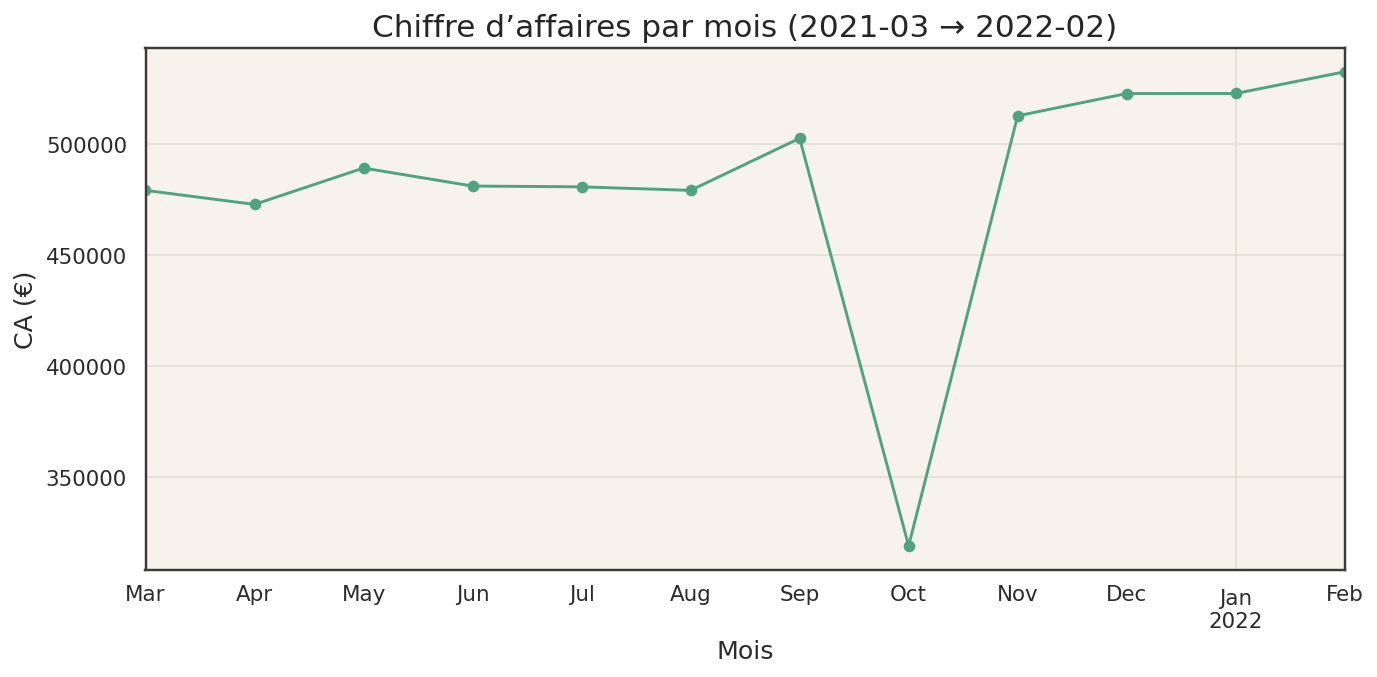

Graphique enregistré sous : figures/Nombre_de_transactions__lignes__par_mois.png


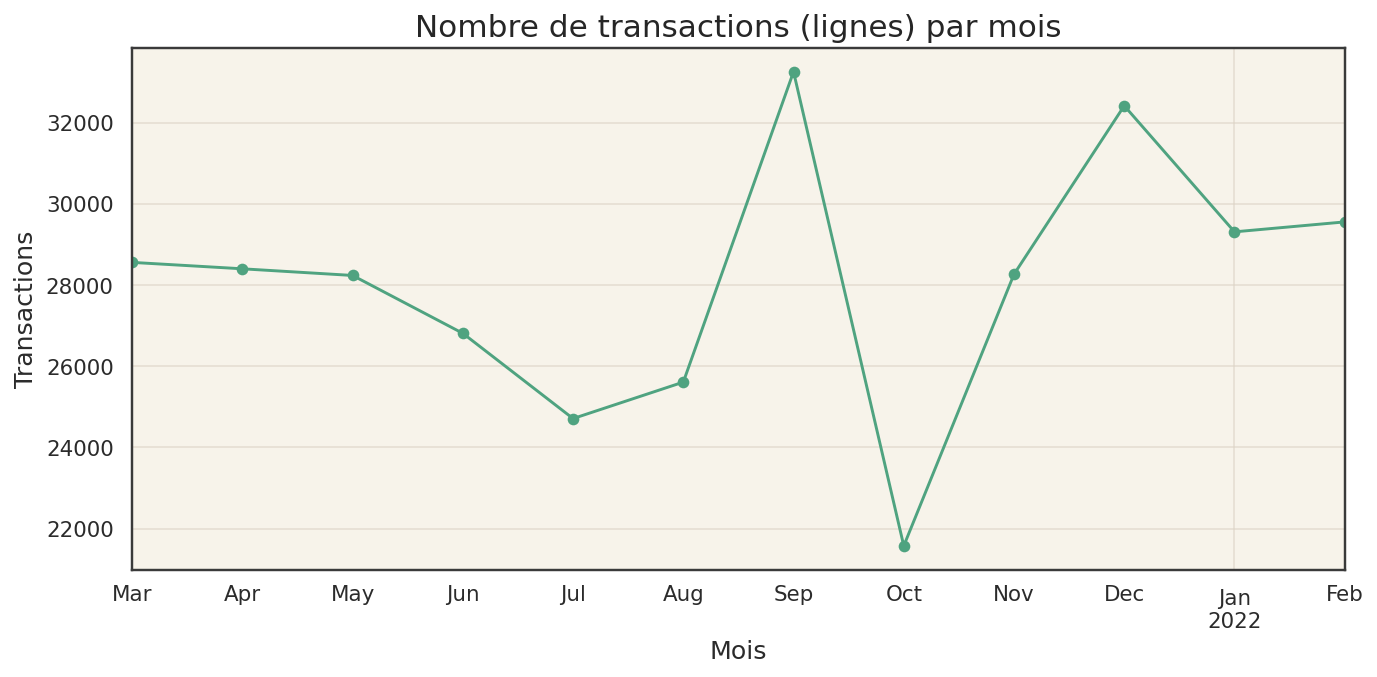

In [372]:
plt.figure(figsize=(10,5))
df_ca_mensuel.plot(marker="o", title="Chiffre d’affaires par mois (2021-03 → 2022-02)")
plt.ylabel("CA (€)")
plt.xlabel("Mois")
plt.tight_layout()

# Récupérer le titre
title = plt.gca().get_title()

# Nettoyer le titre pour qu’il devienne un nom de fichier valide
safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)

# Créer le dossier de sauvegarde si nécessaire
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# Construire le chemin complet
file_path = os.path.join(output_dir, f"{safe_title}.png")

# Sauvegarder la figure
plt.savefig(file_path, dpi=300, bbox_inches='tight')

print(f" Graphique enregistré sous : {file_path}")


plt.show()

plt.figure(figsize=(10,5))
tx_mensuel.plot(marker="o", title="Nombre de transactions (lignes) par mois")
plt.ylabel("Transactions")
plt.xlabel("Mois")
plt.tight_layout()
# Récupérer le titre
title = plt.gca().get_title()


safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, f"{safe_title}.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Graphique enregistré sous : {file_path}")
plt.show()


on remarque une incohérence au mois d'octobre, on va donc essayer de comprendre ce qui ce passe durant ce mois: création d'une df ciblée

####*analyse des transaction du mois d'octobre*

In [373]:
# Diagnostic complémentaire sur Octobre 2021
oct21_vol = df_tf[df_tf["month"] == "2021-10"]

print("Transactions Oct 2021 :", oct21_vol.shape) #(nombre de transaction,nb variables conservées)
print(oct21_vol["price"].describe())       # prix anormaux ?

Transactions Oct 2021 : (21577, 10)
count   21577.00
mean       14.79
std        17.54
min         0.62
25%         6.99
50%        11.03
75%        15.99
max       247.22
Name: price, dtype: float64


In [374]:
# Prix moyen par mois
prix_moyen_mensuel = (
    df_tf.groupby("month", observed=True)["price"].mean().sort_index()
)
print(prix_moyen_mensuel)



month
2021-03   16.78
2021-04   16.65
2021-05   17.33
2021-06   17.95
2021-07   19.46
2021-08   18.72
2021-09   15.12
2021-10   14.79
2021-11   18.14
2021-12   16.13
2022-01   17.84
2022-02   18.02
Freq: M, Name: price, dtype: float64


In [375]:
oct_mask = (df_tf["month"] == pd.Period("2021-10"))
print("CA moyen Oct 2021 :", df_tf.loc[oct_mask, "price"].mean())
print("CA moyen autres mois :", df_tf.loc[~oct_mask, "price"].mean())


CA moyen Oct 2021 : 14.791674468183714
CA moyen autres mois : 17.38112373705321


In [376]:
# CA moyen par transaction en octobre vs autres
print("CA moyen Oct 2021 :", oct21_vol["price"].mean())
print("CA moyen autres mois :", df_tf[df_tf["month"] != "2021-10"]["price"].mean())

CA moyen Oct 2021 : 14.791674468183714
CA moyen autres mois : 17.38112373705321


In [377]:
# on fait une fenêtre de comparaison Sep–Nov
cmp = (
    df_tf[df_tf["month"].isin(pd.period_range("2021-09","2021-11", freq="M"))]
    .groupby("month", observed=True)
    .agg(
        tx=("price","size"),                     # lignes/transactions
        ca=("price","sum"),
        sessions=("session_id","nunique"),
        panier_moyen=("price","mean")
    )
    .sort_index()
)
print(cmp)


            tx        ca  sessions  panier_moyen
month                                           
2021-09  33254 502771.28     14848         15.12
2021-10  21577 319159.96     11551         14.79
2021-11  28267 512890.17     14605         18.14


Octobre 2021 présente un chiffre d’affaires exceptionnellement bas: 319 k€ vs ~ 490 k€ en moyenne mensuelle. La chute est de −35 % par rapport à la moyenne mensuelle. Cela correspond à un manque d’environ 171 k€, soit ~3 % du CA total sur la période.

L’analyse détaillée montre que le prix moyen reste stable: ~15 €, mais que le nombre de transactions enregistrées 21 577 est nettement inférieur à celui des mois voisins: ~30–35k.

Cela reste faible à l’échelle globale, mais significatif dans une analyse mensuelle, car le mois d’octobre apparaît artificiellement comme une contre-performance.

Cette baisse est donc sans doute liée à un volume de transactions incomplet (probablement dû à un à un volume de transactions incomplet (probablement dû à un problème de collecte ou d’intégration des données)
à un incident opérationnel ( indisponibilité du site, bug technique ayant limité les ventes etc...)
et non à une variation commerciale réelle.




In [378]:
# Harmonisation (ex. en entier nullable)

all_categ = set(df_tf["categ"].dropna().unique())
oct_categ = set(df_tf.loc[df_tf["month"] == pd.Period("2021-10"), "categ"].dropna().unique())
missing_categ = all_categ - oct_categ

print("Toutes catégories :", all_categ)
print("Catégories en octobre :", oct_categ)
print("Catégories manquantes en octobre :", missing_categ)



Toutes catégories : {np.int64(0), np.int64(1), np.int64(2)}
Catégories en octobre : {np.int64(0), np.int64(1), np.int64(2)}
Catégories manquantes en octobre : set()


In [379]:
df_tmp = df_tf.copy()
df_tmp["day"] = df_tmp["date"].dt.floor("D")

idx = pd.date_range("2021-10-01", "2021-10-31", freq="D")
df_oct = df_tmp[df_tmp["month"] == pd.Period("2021-10")].copy()

# Série quotidienne : transactions et CA (mois complet, jours manquants = 0)
tx_day = df_oct.groupby("day").size().reindex(idx, fill_value=0)
ca_day = df_oct.groupby("day")["price"].sum().reindex(idx, fill_value=0)

jours_vides = list(tx_day[tx_day == 0].index.date)
print("Jours sans transactions en octobre :", jours_vides)


Jours sans transactions en octobre : []


In [380]:
# indx Octobre 2021
idx = pd.date_range("2021-10-01", "2021-10-31", freq="D")
df_oct = df_tf[df_tf["month"] == pd.Period("2021-10")].copy()
df_oct["day"] = df_oct["date"].dt.floor("D")

#  Pivot transactions/jour × catégorie + controle
pivot_oct = (
    df_oct.pivot_table(index="day",
                       columns="categ",
                       values="id_prod",
                       aggfunc="count",
                       fill_value=0)
    .reindex(idx, fill_value=0)                  # jours sans données
    .sort_index()
)

# Totaux et parts
pivot_oct["nb_tx_total"] = pivot_oct.sum(axis=1)
parts_oct = pivot_oct.div(pivot_oct["nb_tx_total"].replace({0:1}), axis=0)  # parts par jour (évite /0)
parts_oct = parts_oct.drop(columns=["nb_tx_total"], errors="ignore")

print(pivot_oct.head(31))

categ         0    1   2  nb_tx_total
2021-10-01  662  344  37         1043
2021-10-02  660    0  27          687
2021-10-03  647    0  30          677
2021-10-04  600    0  37          637
2021-10-05  594    0  38          632
2021-10-06  701    0  25          726
2021-10-07  597    0  26          623
2021-10-08  669    0  44          713
2021-10-09  640    0  35          675
2021-10-10  599    0  28          627
2021-10-11  642    0  42          684
2021-10-12  632    0  29          661
2021-10-13  633    0  36          669
2021-10-14  605    0  39          644
2021-10-15  632    0  37          669
2021-10-16  661    0  45          706
2021-10-17  625    0  44          669
2021-10-18  608    0  37          645
2021-10-19  565    0  37          602
2021-10-20  554    0  42          596
2021-10-21  610    0  43          653
2021-10-22  571    0  34          605
2021-10-23  555    0  47          602
2021-10-24  584    0  44          628
2021-10-25  545    0  32          577
2021-10-26  

In [381]:
absence_par_categ = (pivot_oct.drop(columns="nb_tx_total", errors="ignore") == 0).sum()
print("Jours d’absence par catégorie en octobre :", absence_par_categ.sort_values(ascending=False))


Jours d’absence par catégorie en octobre : categ
1    26
0     0
2     0
dtype: int64


Graphique enregistré sous : figures/Nombre_de_transactions__lignes__par_mois.png


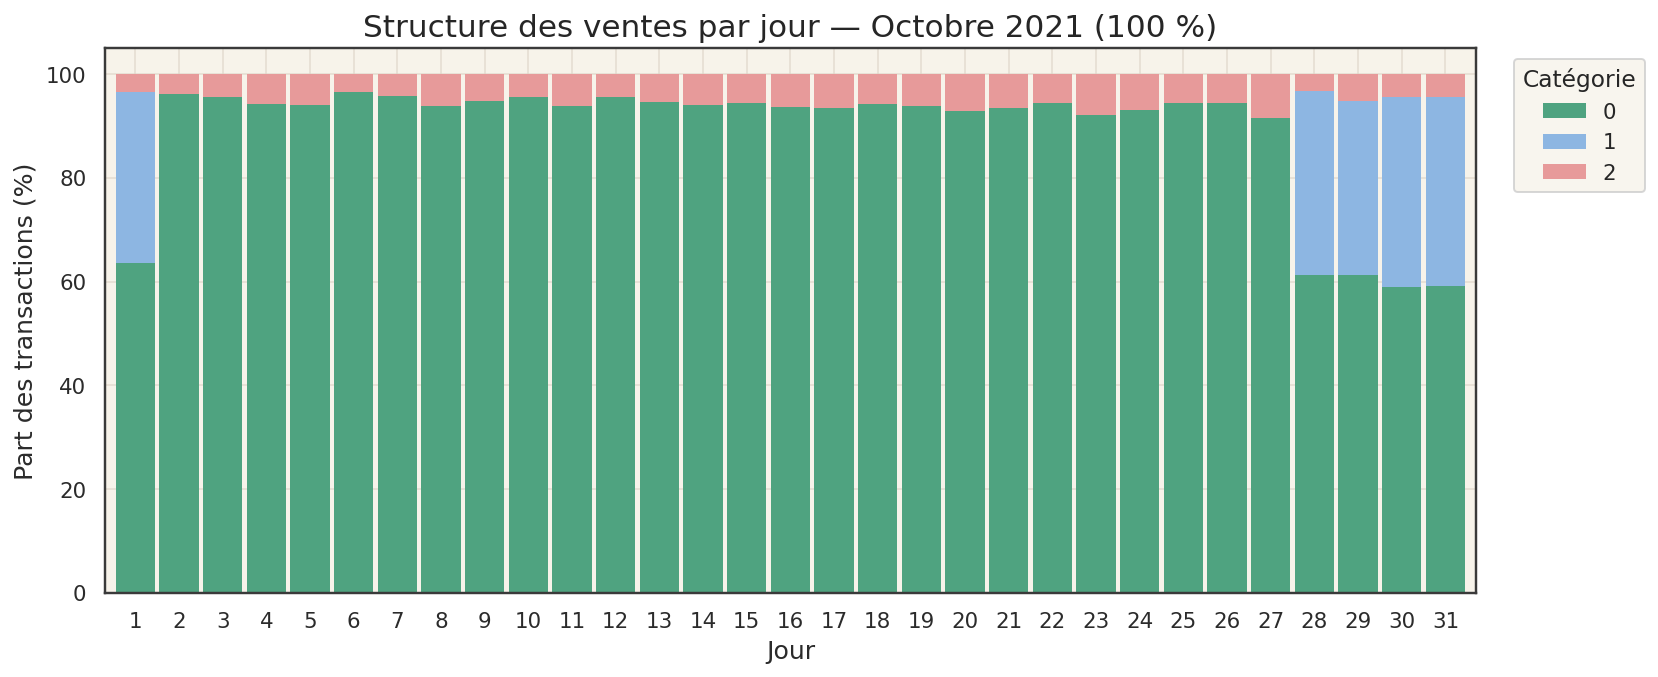

In [382]:
ax = (100*parts_oct).plot(kind="bar", stacked=True, figsize=(12,5), width=0.9, edgecolor="none")
plt.title("Structure des ventes par jour — Octobre 2021 (100 %)")
plt.ylabel("Part des transactions (%)")
plt.xlabel("Jour")
plt.xticks(ticks=range(len(parts_oct.index)), labels=[d.day for d in parts_oct.index], rotation=0)
plt.legend(title="Catégorie", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout();
safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, f"{safe_title}.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Graphique enregistré sous : {file_path}")
plt.show()


 Graphique enregistré sous : figures/Chiffre_d_affaires_par_mois__2021-03___2022-02_.png


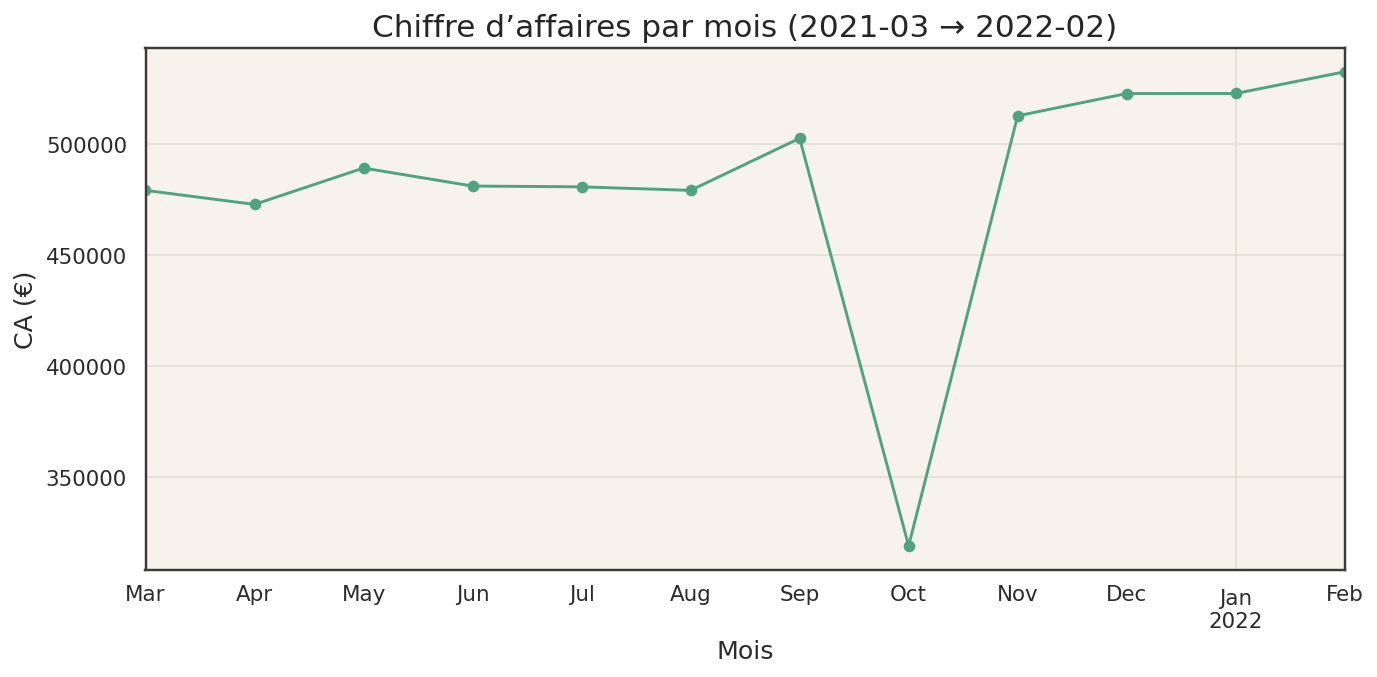

Graphique enregistré sous : figures/Nombre_de_transactions__lignes__par_mois.png


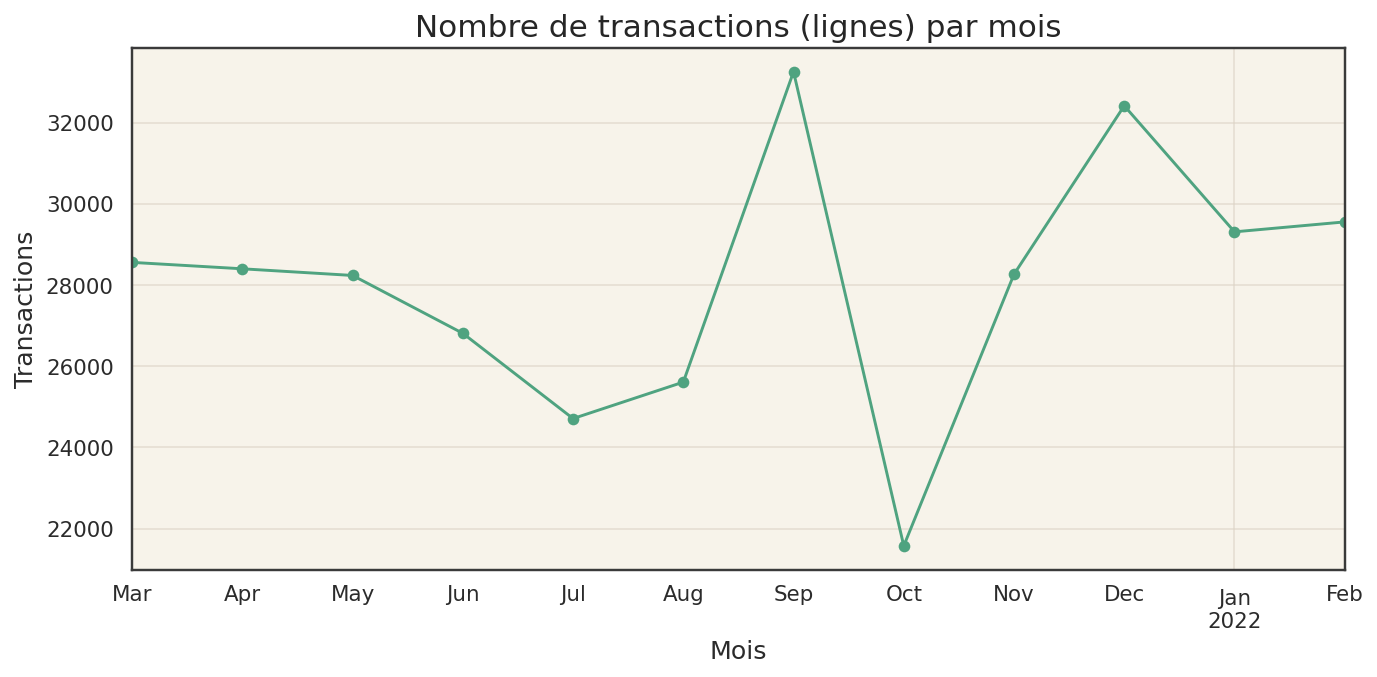

In [383]:
plt.figure(figsize=(10,5))
df_ca_mensuel.plot(marker="o", title="Chiffre d’affaires par mois (2021-03 → 2022-02)")
plt.ylabel("CA (€)")
plt.xlabel("Mois")
plt.tight_layout()

# Récupérer le titre
title = plt.gca().get_title()

# Nettoyer le titre pour qu’il devienne un nom de fichier valide
safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)

# Créer le dossier de sauvegarde si nécessaire
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)

# Construire le chemin complet
file_path = os.path.join(output_dir, f"{safe_title}.png")

# Sauvegarder la figure
plt.savefig(file_path, dpi=300, bbox_inches='tight')

print(f" Graphique enregistré sous : {file_path}")


plt.show()

plt.figure(figsize=(10,5))
tx_mensuel.plot(marker="o", title="Nombre de transactions (lignes) par mois")
plt.ylabel("Transactions")
plt.xlabel("Mois")
plt.tight_layout()
# Récupérer le titre
title = plt.gca().get_title()


safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, f"{safe_title}.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Graphique enregistré sous : {file_path}")
plt.show()


Graphique enregistré sous : figures/Nombre_de_transactions__lignes__par_mois.png


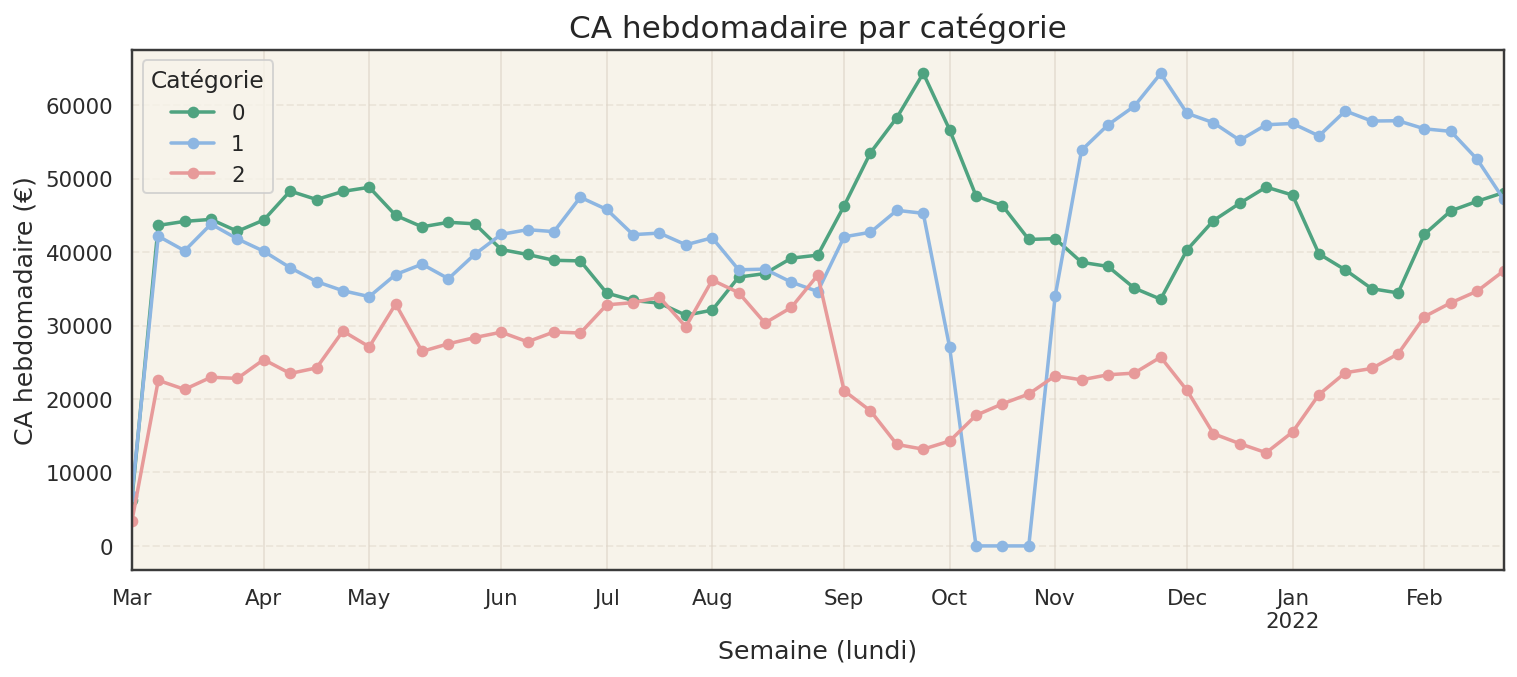

In [384]:
df = df_tf.copy()

# Index temporel + agrégation hebdo (lundi)
df = df.set_index("date")
weekly = (
    df.groupby("categ")["price"]
      .resample("W-MON")
      .sum()
      .unstack(0)
      .sort_index()
)

ax = weekly.plot(figsize=(11,5), linewidth=1.8)
ax.set_title("CA hebdomadaire par catégorie")
ax.set_xlabel("Semaine (lundi)")
ax.set_ylabel("CA hebdomadaire (€)")
ax.grid(True, axis="y", linestyle="--", alpha=0.4)
ax.legend(title="Catégorie", loc="upper left")
plt.tight_layout();

safe_title = re.sub(r'[^a-zA-Z0-9_\-]', '_', title)
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
file_path = os.path.join(output_dir, f"{safe_title}.png")
plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"Graphique enregistré sous : {file_path}")
plt.show()

L’analyse montre une perte de données sur la catégorie 1 entre le 2 et le 28 octobre 2021, alors que cette catégorie est présente aux fréquences habituelles sur les autres périodes.

Deux options étaient envisageables :

Corriger octobre en imputant les données manquantes par interpolation (moyenne entre septembre et novembre).

Exclure octobre des calculs afin de ne conserver que des valeurs réellement observées.

Nous avons choisi la seconde option : supprimer le mois d’octobre 2021 des analyses. Cela permet de travailler sur une base de 11 mois complets reflétant un chiffre d’affaires réel, sans introduire d’estimation artificielle.

### Analyse par produit

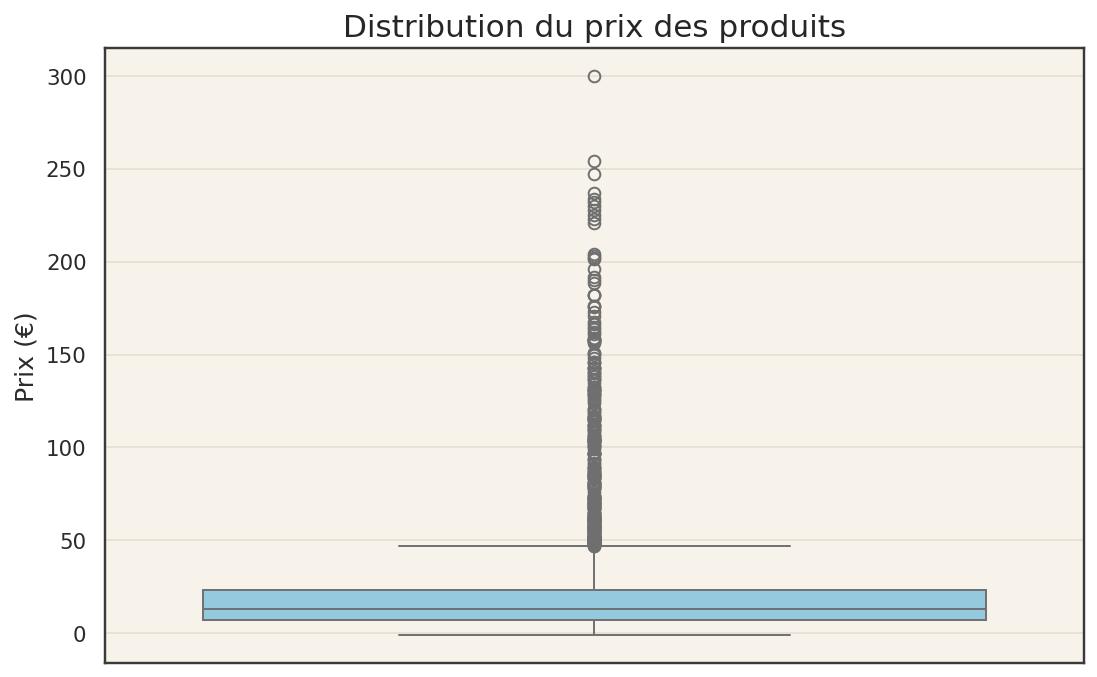

In [385]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_products, y="price", color="skyblue", showfliers=True)
plt.title("Distribution du prix des produits")
plt.ylabel("Prix (€)")
plt.xlabel("")
plt.tight_layout()
plt.show()

####Top 5 des produits

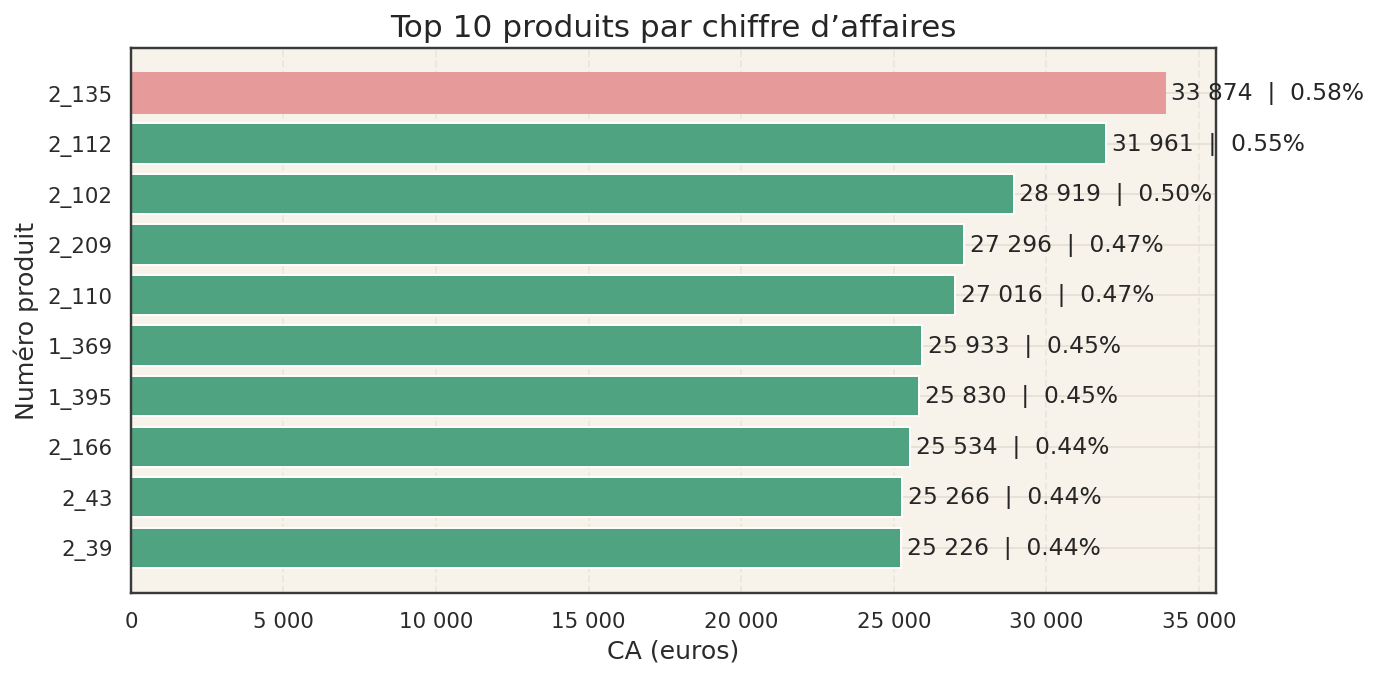

In [386]:

# CA par produit (1 id_prod = 1 achat)
df = df_tf.copy()
if "quantity" in df.columns:
    df["ca_ligne"] = pd.to_numeric(df["price"], errors="coerce") * pd.to_numeric(df["quantity"], errors="coerce")
else:
    df["ca_ligne"] = pd.to_numeric(df["price"], errors="coerce")

df = df.dropna(subset=["id_prod", "ca_ligne"])
df = df[df["ca_ligne"] > 0]

# --- Top 10 produits ---
top = (
    df.groupby("id_prod", observed=True)["ca_ligne"]
      .sum()
      .nlargest(10)
      .sort_values(ascending=True)      # pour barh
)

ca_total = df["ca_ligne"].sum()

# Etiquette
fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(y=top.index.astype(str), width=top.values)
bars[-1].set_color("#E79A9A")  # rouge pastel


# au bout  "montant + pourcentage"
labels_text = [
    f"{v:,.0f}".replace(",", " ") + "  |  " + f"{(v/ca_total):.2%}"
    for v in top.values
]
# bar_label
try:
    ax.bar_label(bars, labels=labels_text, label_type="edge", padding=3)
except Exception:
    xmax = float(top.values.max())
    for rect, txt in zip(bars, labels_text):
        x = rect.get_width()
        y = rect.get_y() + rect.get_height()/2
        ax.text(x + xmax*0.02, y, txt, va="center")

ax.set_title("Top 10 produits par chiffre d’affaires")
ax.set_xlabel("CA (euros)")
ax.set_ylabel("Numéro produit")
ax.xaxis.set_major_formatter(lambda x, pos: f"{x:,.0f}".replace(",", " "))
ax.grid(True, axis="x", linestyle="--", alpha=0.35)

plt.tight_layout()
plt.show()


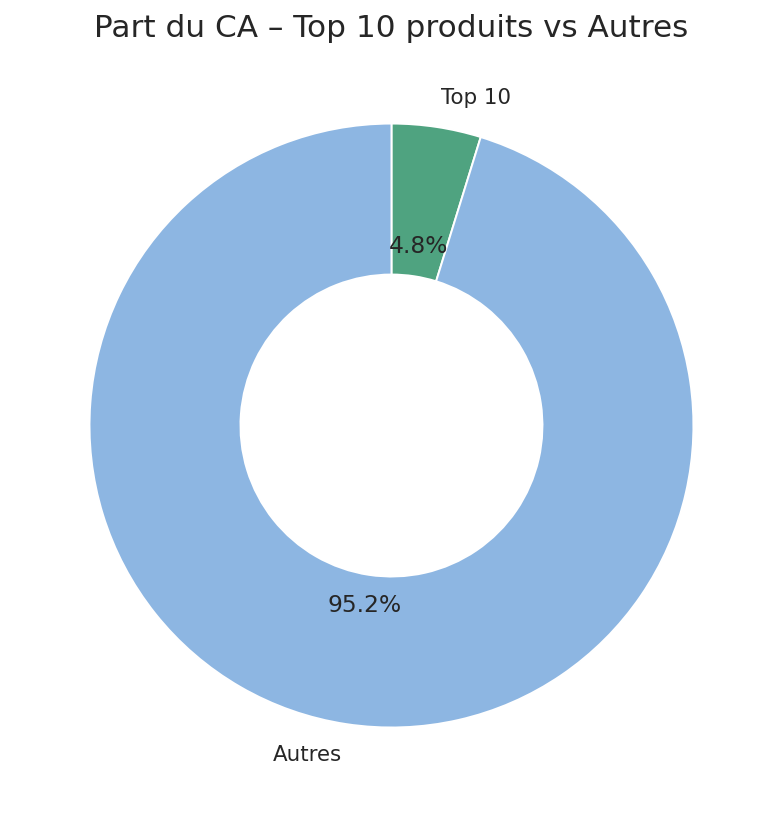

In [387]:
# Donut Top10 vs Autres
top10_sum = top_products.sum()
others_sum = ca_total - top10_sum

fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    [top10_sum, others_sum],
    labels=["Top 10", "Autres"],
    autopct=lambda p: f"{p:.1f}%",
    startangle=90,
    counterclock=False
)
# Donut (anneau)
for w in wedges:
    w.set_width(0.5)

ax.set_title("Part du CA – Top 10 produits vs Autres")
plt.tight_layout()
plt.show()

Les 10 produits les plus vendus génèrent chacun entre 25 k€ et 34 k€ sur la période, soit 0,44 % à 0,58 % du CA total.

 Cela montre que le chiffre d’affaires n’est pas concentré sur quelques références, mais réparti sur un très grand nombre de produits. Même le produit leader (2_135) ne représente que 0,6 % du CA global.


### Analyse par catégorie.

#### produits phares par catégorie.

<Axes: title={'center': 'Nombre de produits uniques par catégorie'}, xlabel='categ'>

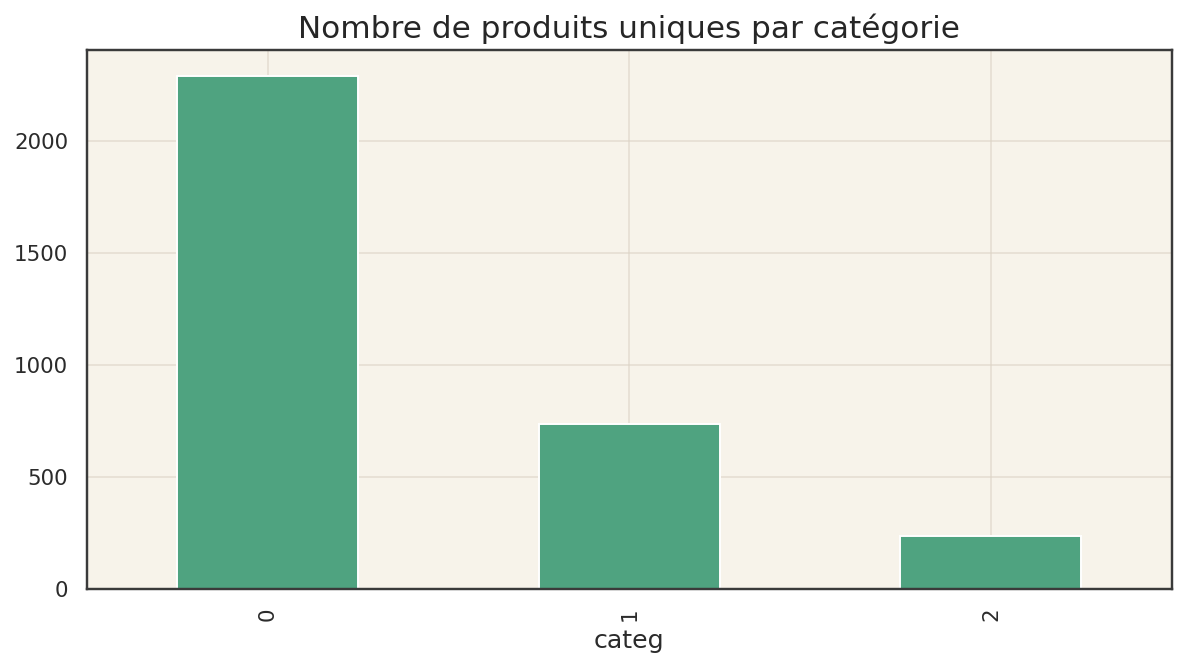

In [388]:
df_tf.groupby("categ")["id_prod"].nunique().plot(kind="bar", title="Nombre de produits uniques par catégorie")

In [389]:
vc = df_tf["price"].value_counts()
print("Global:", vc.idxmax(), vc.max())
for c, s in df_tf.groupby("categ")["price"]:
    vc = s.value_counts()
    print(f"Categ {c}:", (vc.idxmax() if not vc.empty else np.nan), (vc.max() if not vc.empty else 0))


Global: 15.99 10563
Categ 0: 4.99 9306
Categ 1: 15.99 4865
Categ 2: 68.99 1085


In [390]:
# Prix modes déjà identifiés
modes = {
    "ALL": 15.99,
    0: 4.99,
    1: 15.99,
    2: 68.99,
}

df = df_tf.copy()
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["categ"] = pd.to_numeric(df["categ"], errors="coerce").astype("Int64")
df = df.dropna(subset=["price"])

def synth(scope, price_mode, cat=None):
    sub = df if cat is None else df[df["categ"] == cat]
    n = len(sub)
    n_mode = (sub["price"] == price_mode).sum()
    ca = sub["price"].sum()
    ca_mode = sub.loc[sub["price"] == price_mode, "price"].sum()
    return {
        "scope": scope,
        "prix_mode": price_mode,
        "freq": n_mode,
        "freq_%": 100 * n_mode / n if n else 0.0,
        "CA_part_%": 100 * ca_mode / ca if ca else 0.0,
    }

rows = [
    synth("Global", modes["ALL"], None),
    synth("Cat 0", modes[0], 0),
    synth("Cat 1", modes[1], 1),
    synth("Cat 2", modes[2], 2),
]
import pandas as pd
tbl = pd.DataFrame(rows)
print(tbl.round({"freq_%":2, "CA_part_%":2}))


    scope  prix_mode   freq  freq_%  CA_part_%
0  Global      15.99  10563    3.14       2.91
1   Cat 0       4.99   9306    4.44       2.08
2   Cat 1      15.99   4865    4.43       3.46
3   Cat 2      68.99   1085    6.18       5.67


On constate des produits paliers(leaders) pour chaque catégorie croissant de la cat 0 à 2

On vérifie s'il y a une dépendance à un produit:

In [391]:
modes = {None: 15.99, 0: 4.99, 1: 15.99, 2: 68.99}  # global=None facultatif
df = df_tf.copy()
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["categ"] = pd.to_numeric(df["categ"], errors="coerce").astype("Int64")
df = df.dropna(subset=["price"])

def ca_part_for(mode_price, cat=None):
    sub = df if cat is None else df[df["categ"] == cat]
    ca_tot = sub["price"].sum()
    ca_mode = sub.loc[sub["price"] == mode_price, "price"].sum()
    return (ca_mode / ca_tot) if ca_tot else 0.0

print("Part du CA au prix 15.99 (global) :", f"{ca_part_for(15.99):.1%}")
print("Part du CA cat0 au prix 4.99     :", f"{ca_part_for(4.99, 0):.1%}")
print("Part du CA cat1 au prix 15.99    :", f"{ca_part_for(15.99, 1):.1%}")
print("Part du CA cat2 au prix 68.99    :", f"{ca_part_for(68.99, 2):.1%}")


Part du CA au prix 15.99 (global) : 2.9%
Part du CA cat0 au prix 4.99     : 2.1%
Part du CA cat1 au prix 15.99    : 3.5%
Part du CA cat2 au prix 68.99    : 5.7%


In [392]:
for p in [15.99, 4.99, 68.99]:
    top_ids = (df.loc[df["price"] == p]
                 .groupby("id_prod")["price"].size()
                 .sort_values(ascending=False).head(5))
    print(f"Top produits au prix {p} :")
    print(top_ids)


Top produits au prix 15.99 :
id_prod
1_407     933
1_381     842
1_483     690
1_459     687
0_1473    571
Name: price, dtype: int64
Top produits au prix 4.99 :
id_prod
0_1409    615
0_1405    576
0_1447    529
0_1449    497
0_1467    490
Name: price, dtype: int64
Top produits au prix 68.99 :
id_prod
2_135    491
2_163    265
2_41     192
2_127    137
Name: price, dtype: int64


Prix moyen des articles par catégorie.

In [393]:
# 1) CA par catégorie (somme des prix, 1 ligne = 1 article vendu)
ca_by_categ = (
    df.groupby("categ", as_index=False)["price"]
      .sum()
      .rename(columns={"price": "CA"})
)

# 2) Volume (unités vendues = nombre de lignes)
effectif = (
    df["categ"].value_counts(dropna=False)
      .rename_axis("categ")
      .reset_index(name="effectif")
)

# 3) Fréquence volumique
n_total = len(df)
effectif["freq_vol"] = effectif["effectif"] / n_total if n_total else 0.0

# 4) Fusion volume + CA
tab = effectif.merge(ca_by_categ, on="categ", how="left").fillna({"CA": 0})

# 5) Part du CA
ca_total = float(df["price"].sum())
tab["pct_CA"] = tab["CA"] / ca_total if ca_total else 0.0

# 6) Prix moyen par article (indicatif)
tab["prix_moy_article"] = tab["CA"] / tab["effectif"]

# 7) Tri
tab = tab.sort_values("CA", ascending=False, ignore_index=True)

tab

,categ,effectif,freq_vol,CA,pct_CA,prix_moy_article
0,1,109735,0.33,2247384.41,0.39,20.48
1,0,209426,0.62,2229722.65,0.38,10.65
2,2,17552,0.05,1319470.71,0.23,75.17


Prix du panier moye par catégorie

In [394]:
# Panier par session (toutes catégories confondues)
panier_session = df.groupby("session_id")["price"].sum().rename("panier_session")

# CA par (session, catégorie)
ca_sess_cat = (
    df.groupby(["session_id","categ"])["price"].sum().rename("CA_sess_cat").reset_index()
)

# Panier moyen par catégorie = moyenne des montants (session, catégorie)
panier_moy_cat = (
    ca_sess_cat.groupby("categ")["CA_sess_cat"].mean()
               .rename("panier_moyen_categ")
               .reset_index()
)

panier_moy_cat

,categ,panier_moyen_categ
0,0,19.74
1,1,26.02
2,2,89.62


#### Analyse des prix par categories

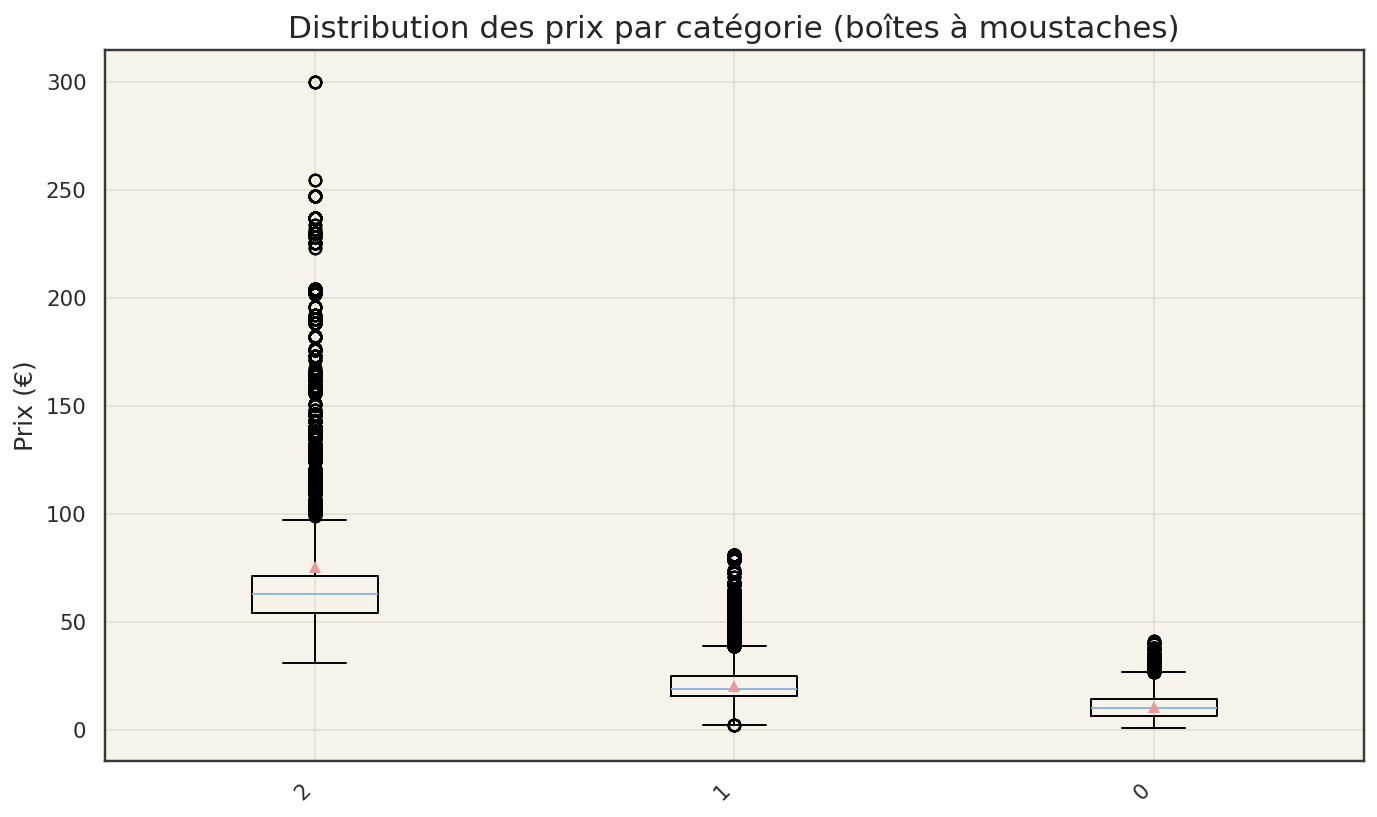

In [395]:

# Préparer les données : une liste de séries de prix par catégorie
order = (
    df.groupby("categ")["price"]
         .median()
         .sort_values(ascending=False)
         .index.tolist()
)
data = [df.loc[df["categ"] == c, "price"].dropna().values for c in order]

plt.figure(figsize=(10,6))
bp = plt.boxplot(
    data,
    vert=True,
    patch_artist=False,   # pas de couleur imposée
    showfliers=True,      # affiche les outliers
    showmeans=True,       # ligne de moyenne
    whis=1.5
)
plt.xticks(range(1, len(order)+1), order, rotation=45, ha="right")
plt.yscale("linear")      # tu peux passer en 'log' si très asymétrique
plt.title("Distribution des prix par catégorie (boîtes à moustaches)")
plt.ylabel("Prix (€)")
plt.tight_layout()
plt.show()


#### Densité des prix par catégorie

/tmp/ipython-input-3705289591.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Catégorie", loc="upper right")


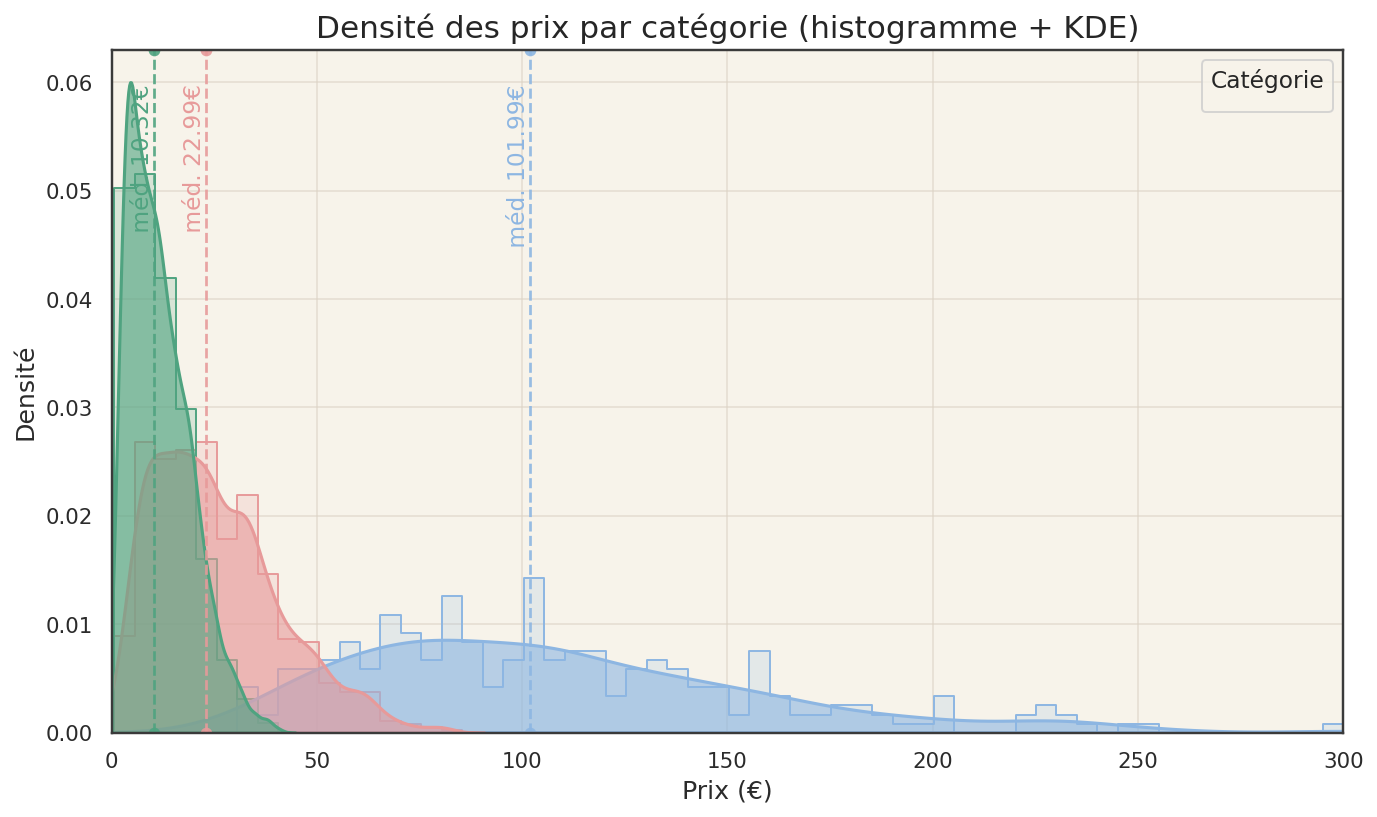

In [396]:
# Hygiène
dfp = df_products.copy()
dfp["price"] = pd.to_numeric(dfp["price"], errors="coerce")
dfp = dfp.dropna(subset=["price", "categ"])
dfp = dfp[dfp["price"] > 0]

# Libellés & palette
cat_map = {0:"cat_0", 1:"cat_1", 2:"cat_2"}
dfp["categ_lbl"] = dfp["categ"].map(cat_map)

PALETTE = ["#4FA380", "#E79A9A", "#8DB6E2"]  # vert / rouge pastel / bleu

plt.figure(figsize=(10,6))

# Histogrammes légers (base de réalité)
sns.histplot(
    data=dfp, x="price", hue="categ_lbl",
    bins=60, element="step", stat="density", common_norm=False,
    alpha=0.18, palette=PALETTE
)

# KDE contrôlée
sns.kdeplot(
    data=dfp, x="price", hue="categ_lbl",
    fill=True, common_norm=False, bw_adjust=0.8, clip=(0, None),
    linewidth=1.6, alpha=0.6, palette=PALETTE
)

# Médianes par catégorie
for (cat, g), col in zip(dfp.groupby("categ_lbl"), PALETTE):
    med = g["price"].median()
    plt.axvline(med, color=col, linestyle="--", linewidth=1.4, alpha=0.9)
    plt.text(med, plt.ylim()[1]*0.95, f" méd. {med:.2f}€", color=col,
             rotation=90, va="top", ha="right")

# Bornes d’axe (ou remplacez par quantiles si besoin)
plt.xlim(0, 300)

plt.title("Densité des prix par catégorie (histogramme + KDE)")
plt.xlabel("Prix (€)")
plt.ylabel("Densité")
plt.legend(title="Catégorie", loc="upper right")
plt.tight_layout(); plt.show()


L’analyse par catégorie met en évidence trois profils distincts :

* **Catégorie 0 – Produits “courants”**
Produits à faible prix unitaire et fort volume : ils représentent 62 % des ventes mais seulement 38 % du chiffre d’affaires.
Les boxplots montrent une distribution de prix resserrée autour de la médiane (~10 €), avec peu de dispersion.
 **Ces articles constituent le socle du volume, mais contribuent seulement a enivorns 40% du CA.**

* **Catégorie 1 – Produits Millieu de gamme** : “équilibrés”
Représentent 33 % des ventes pour 39 % du CA.
Leurs prix sont modérés (médiane autour de 15 €) et plus homogènes, traduisant un positionnement milieu de gamme.
**Cette catégorie agit comme un stabilisateur : elle combine volume régulier et marge moyenne.**

* **Catégorie 2 – Produits haut de gamme** à forte valeur
Faible volume (~5 %) mais ~23 % du CA. Médiane ~102 €, forte dispersion avec queue haute (>200–300 €).
**Ces produits sont clairement haut de gamme, participe a pres d'1/4 du CA globale malgré leur faible fréquence d’achat.**

### Analyse CA par sexe

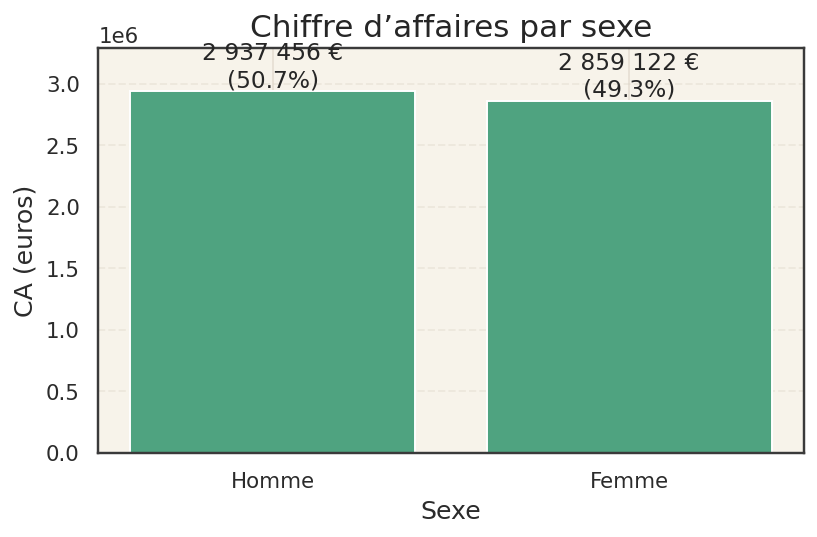

In [397]:
# Normaliser la variable sex et libeller
df_ = df.copy()
df_["sex"] = df_["sex"].astype("string").str.strip().str.upper()
df_["sex_lbl"] = df_["sex"].map({"F": "Femme", "M": "Homme"}).fillna("Inconnu")

# CA par sexe (tri décroissant pour lecture)
ca_by_sex = (
    df_.groupby("sex_lbl", observed=True)["price"]
       .sum()
       .sort_values(ascending=False)
)

# Tracé unique
fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(ca_by_sex.index, ca_by_sex.values)

ax.set_title("Chiffre d’affaires par sexe")
ax.set_xlabel("Sexe"); ax.set_ylabel("CA (euros)")
ax.grid(True, axis="y", linestyle="--", alpha=0.35)

#étiquettes
ymax = float(ca_by_sex.max()) * 1.12
ax.set_ylim(0, ymax)

# Annotation
total = float(ca_by_sex.sum())
for rect, val in zip(bars, ca_by_sex.values):
    ax.text(
        rect.get_x() + rect.get_width()/2, rect.get_height(),
        f"{val:,.0f} €\n({val/total:.1%})".replace(",", " "),
        ha="center", va="bottom"
    )

plt.tight_layout()
plt.show()

CA Equilibré entre les Hommes et les Femmes



L’analyse par âge montre que la clientèle est surtout concentrée entre 35 et 50 ans en volume.

En termes de valeur :

Le CA moyen par client est le plus élevé chez les **30–55 ans**, confirmant qu’il s’agit de la cible **principale**.

Les clients plus jeunes (<30 ans) et plus âgés (>70 ans) dépensent significativement moins, ce qui réduit leur poids économique malgré leur présence.

Cela suggère que les actions marketing ou de **fidélisation** devraient cibler prioritairement les **30–55 ans**, qui combinent à la fois volume et rentabilité. Mais aussi d'établir une nouvelle stratégie pour **attirer fidéliser** les **jeunes adultes et les seniors.**


*  La catégorie 0 regroupe des produits d’entrée de gamme, peu chers ethomogènes.


*   La catégorie 1 se situe dans une gamme intermédiaire, avec des prix plus variés.



*  La catégorie 2 concentre les produits premium, caractérisés par des prix nettement supérieurs et une forte variabilité.


**Cela explique les différences observées dans la contribution au CA par catégorie car la catégorie 2 génère un quart du CA malgré seulement 5 % des volumes.**

## 3. Analyse de concentration : Lorenz & Gini

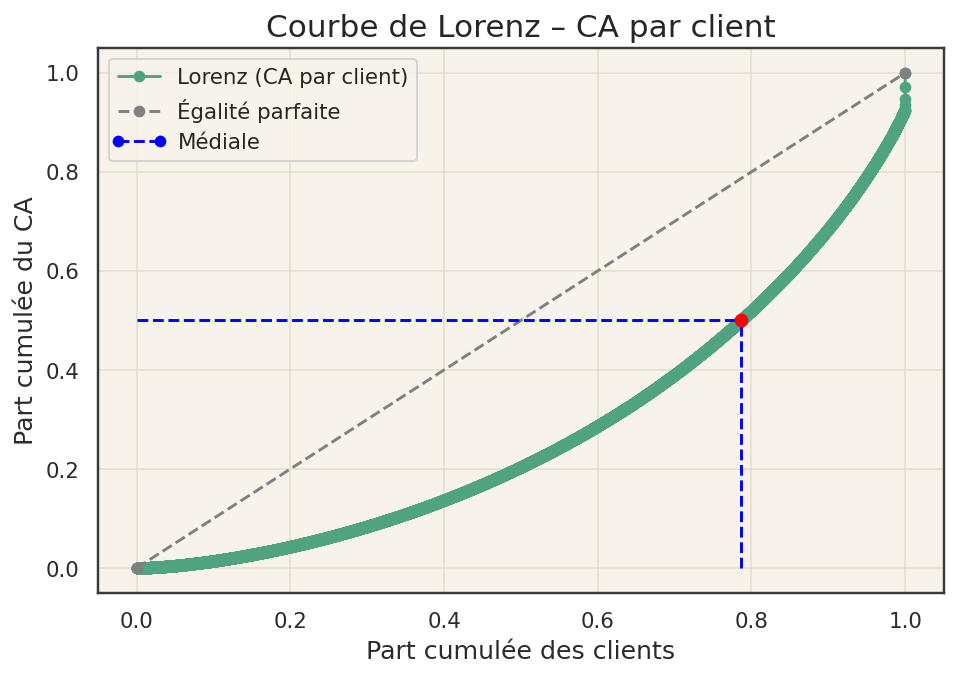

In [398]:
# CA total par client, trié
ca_clients = df.groupby("client_id")["price"].sum().sort_values().values #On calcule le CA total par client.

# 2) Vecteurs x,y avec origine (0,0)
N = len(ca_clients)
x = np.arange(0, N+1) / N                   #génère une séquence 1, 2, 3, … jusqu’au nombre de clients.
y = np.r_[0.0, ca_clients.cumsum() / ca_clients.sum()]  #ordonnée a l'origine #somme cumulée du CA en suivant l’ordre trié/divise par le total pour obtenir une proportion.

# 3) Tracé courbe de Lorenz
plt.figure(figsize=(7,5))
plt.plot(x, y, drawstyle="steps-post", label="Lorenz (CA par client)")
plt.plot([0,1], [0,1], color="grey", linestyle="--", label="Égalité parfaite")


#tracé médial
idx = np.searchsorted(y, 0.5)   # premier indice où y >= 0.5
x_medial = x[idx]
y_medial = y[idx]
plt.vlines(x_medial, ymin=0, ymax=y_medial, color='blue', linestyle='--', label='Médiale')
plt.hlines(y_medial, xmin=0, xmax=x_medial, color='blue', linestyle='--')
plt.scatter([x_medial], [y_medial], color='red', zorder=5)

#label
plt.xlabel("Part cumulée des clients")
plt.ylabel("Part cumulée du CA")
plt.title("Courbe de Lorenz – CA par client")
plt.legend()
plt.tight_layout()
plt.show()

# 4) Indice de Gini (aire sous la courbe)
AUC = np.trapezoid(y, x)      # aire sous la Lorenz
gini = 1 - 2*AUC

In [399]:
print(f"50% du CA est atteint par environ {x_medial:.2%} de la population.")
print(f"Indice de Gini (CA par client) : {gini:.3f}")

50% du CA est atteint par environ 78.63% de la population.
Indice de Gini (CA par client) : 0.440


Des produits à forte valeur qui génèrent beaucoup de CA.

Des clients grands comptes ou très réguliers.

Une stratégie commerciale où peu de transactions font l’essentiel du chiffre d’affaires.

Présence d'outlider

## 4. Distribution des ventes

## Conclusion
- Les ventes sont concentrées sur quelques transactions (indice de Gini élevé).
- La majorité des montants de vente sont faibles.
- Il existe des pics mensuels dans le chiffre d’affaires.
- Les femmes et hommes achètent de façon similaire en moyenne.
- Certains types de produits génèrent plus de revenus que d'autres.

**Recommandation :** cibler les catégories et périodes les plus rentables, et fidéliser les gros acheteurs.

In [400]:
df["CA"] = df["price"]

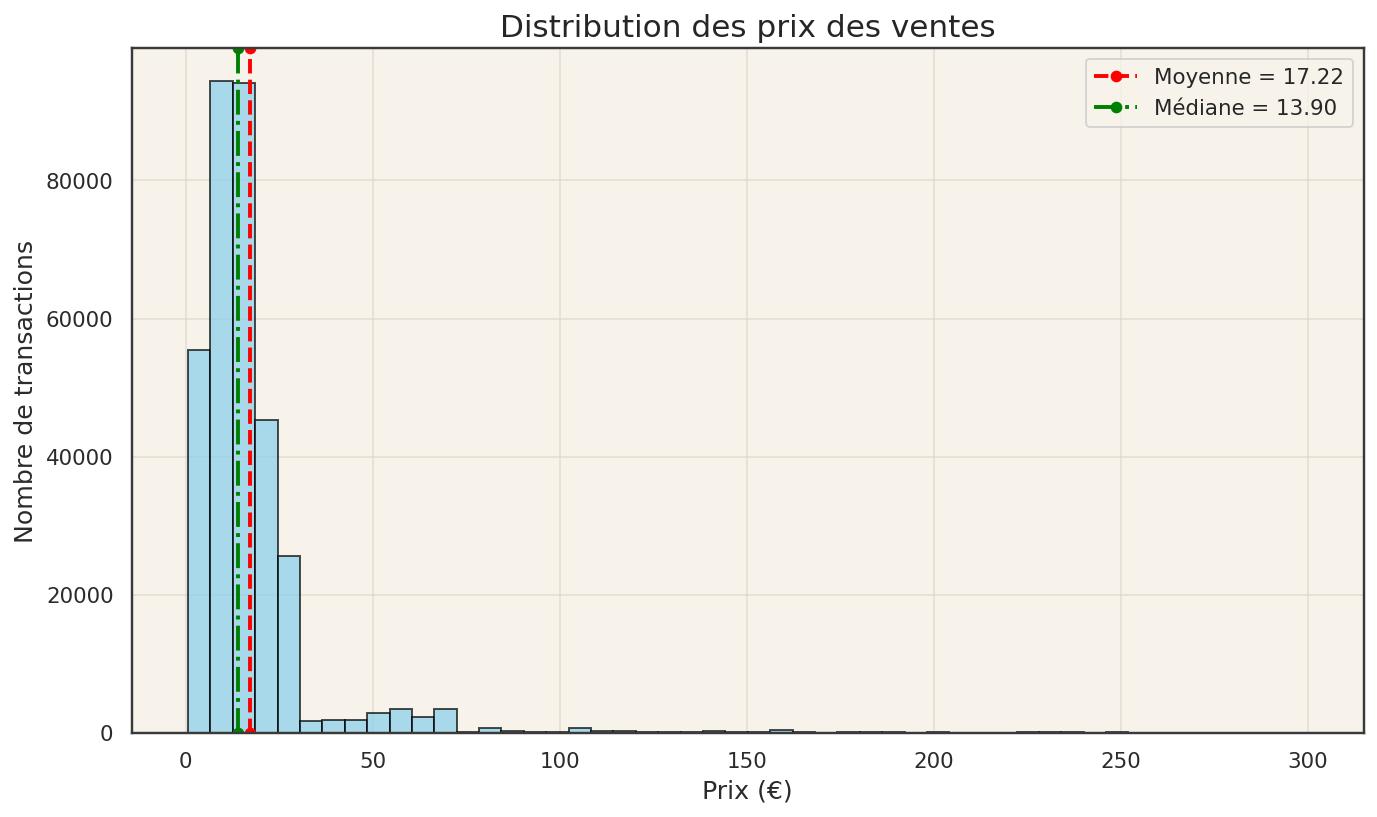

In [401]:
plt.figure(figsize=(10,6))
plt.hist(df["price"], bins=50, color="skyblue", edgecolor="black", alpha=0.7)

# Ajouter lignes pour moyenne et médiane
plt.axvline(df["price"].mean(), color="red", linestyle="--", linewidth=2, label=f"Moyenne = {df['price'].mean():.2f}")
plt.axvline(df["price"].median(), color="green", linestyle="-.", linewidth=2, label=f"Médiane = {df['price'].median():.2f}")

plt.title("Distribution des prix des ventes")
plt.xlabel("Prix (€)")
plt.ylabel("Nombre de transactions")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Comparaison des ventes selon le sexe

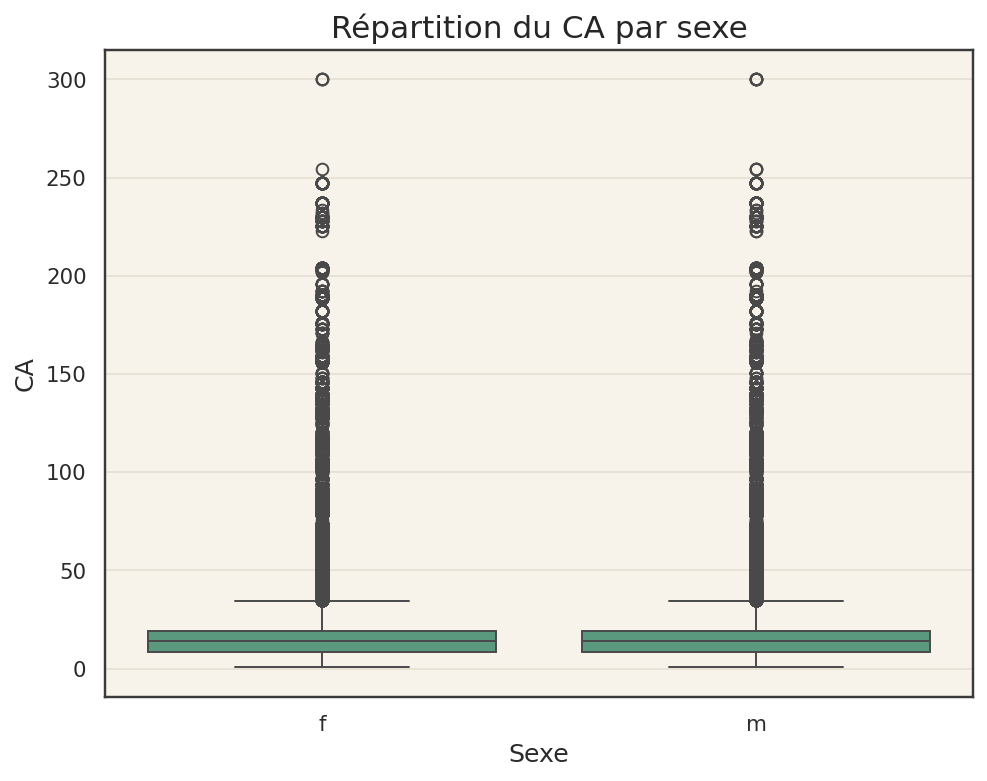

In [402]:
plt.figure(figsize=(8,6))
sns.boxplot(x='sex', y='CA', data=df)
plt.title('Répartition du CA par sexe')
plt.xlabel('Sexe')
plt.ylabel('CA')
plt.show()

## 7. Analyse des ventes par catégorie de produit

/tmp/ipython-input-2812670755.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='categ', y='CA', data=df, estimator=sum, ci=None)


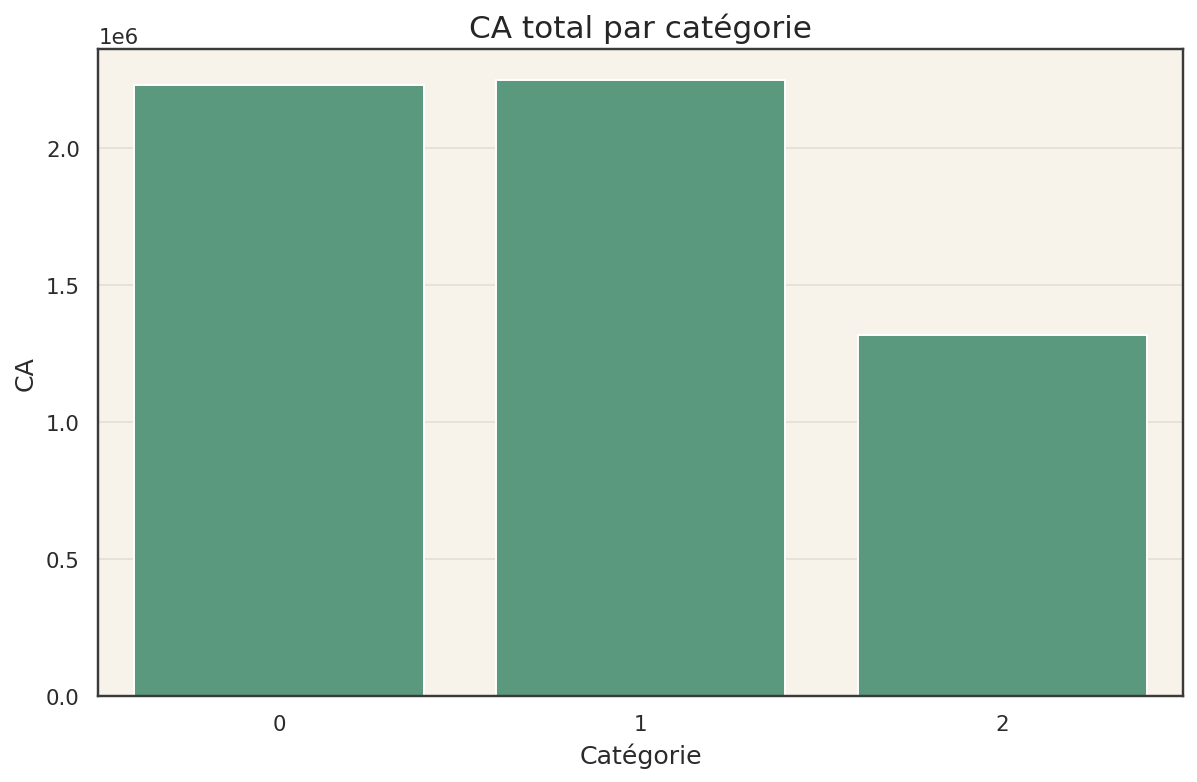

In [404]:
plt.figure(figsize=(10,6))
sns.barplot(x='categ', y='CA', data=df, estimator=sum, ci=None)
plt.title('CA total par catégorie')
plt.xlabel('Catégorie')
plt.ylabel('CA')
plt.show()

## Répartition des âges des clients

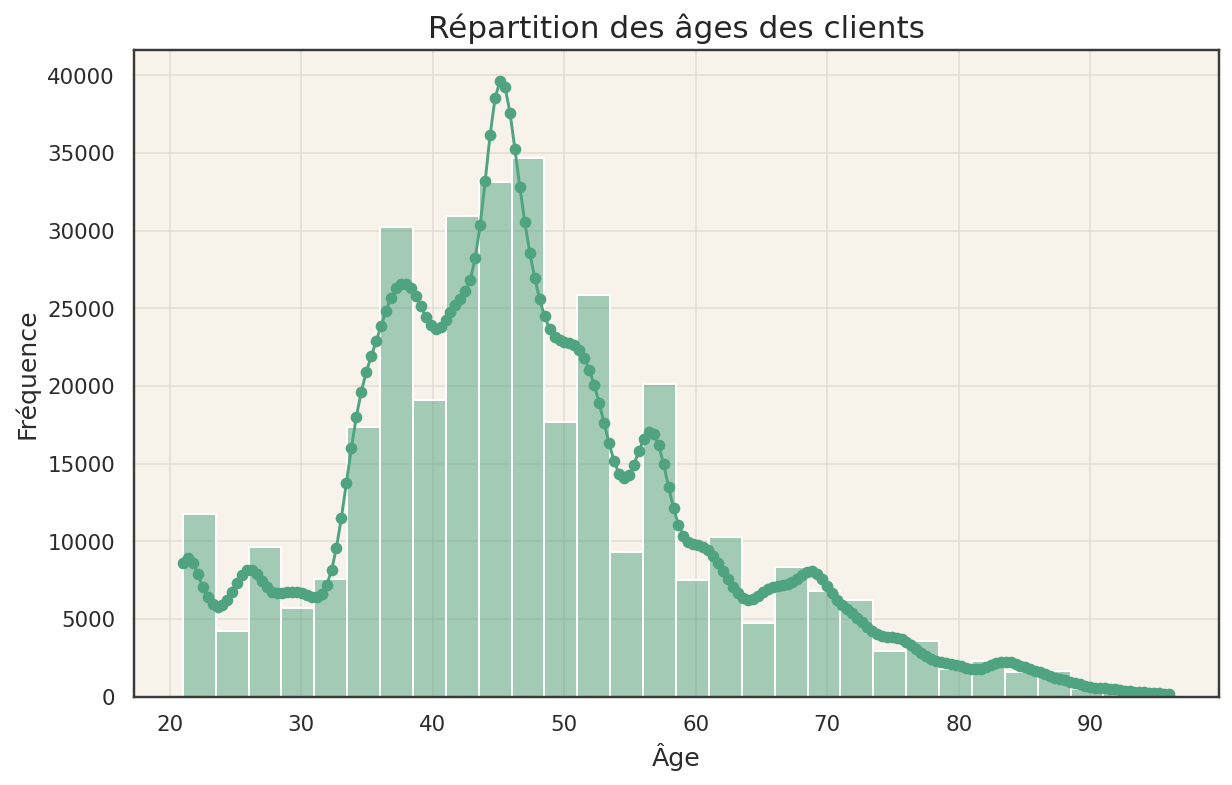

In [405]:
plt.figure(figsize=(10,6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Répartition des âges des clients')
plt.xlabel('Âge')
plt.ylabel('Fréquence')
plt.grid(True)
plt.show()

## Nombre de produits achetés par client

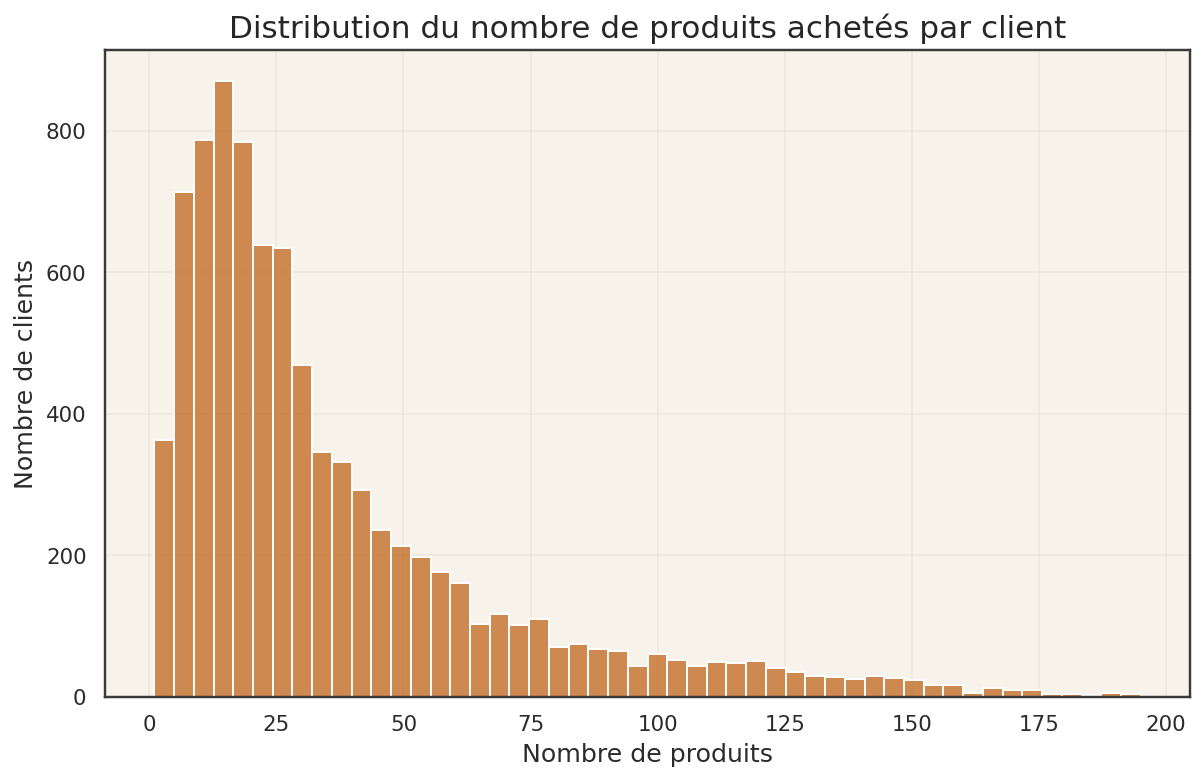

In [406]:
produits_par_client = df.groupby('client_id')["id_prod"].count()
plt.figure(figsize=(10,6))
sns.histplot(produits_par_client[produits_par_client < 500], bins=50, color="#C1661C")
plt.title("Distribution du nombre de produits achetés par client")
plt.xlabel("Nombre de produits")
plt.ylabel("Nombre de clients")
plt.grid(True, alpha=0.3)
plt.show()

## Répartition des prix par catégorie de produit

## Chiffre d'affaires moyen par client

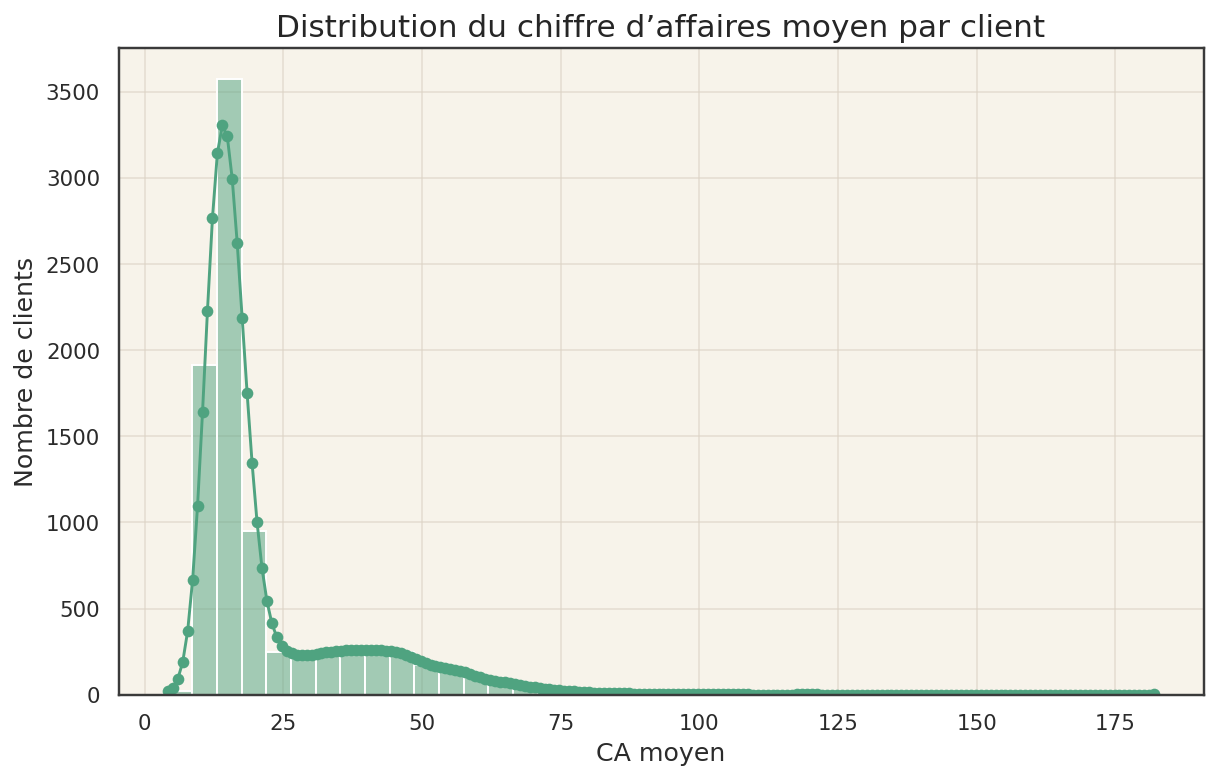

In [407]:
ca_moyen = df.groupby('client_id')['CA'].mean()
plt.figure(figsize=(10,6))
sns.histplot(ca_moyen, bins=40, kde=True)
plt.title('Distribution du chiffre d’affaires moyen par client')
plt.xlabel('CA moyen')
plt.ylabel('Nombre de clients')
plt.grid(True)
plt.show()

## Relation entre l’âge et le chiffre d’affaires

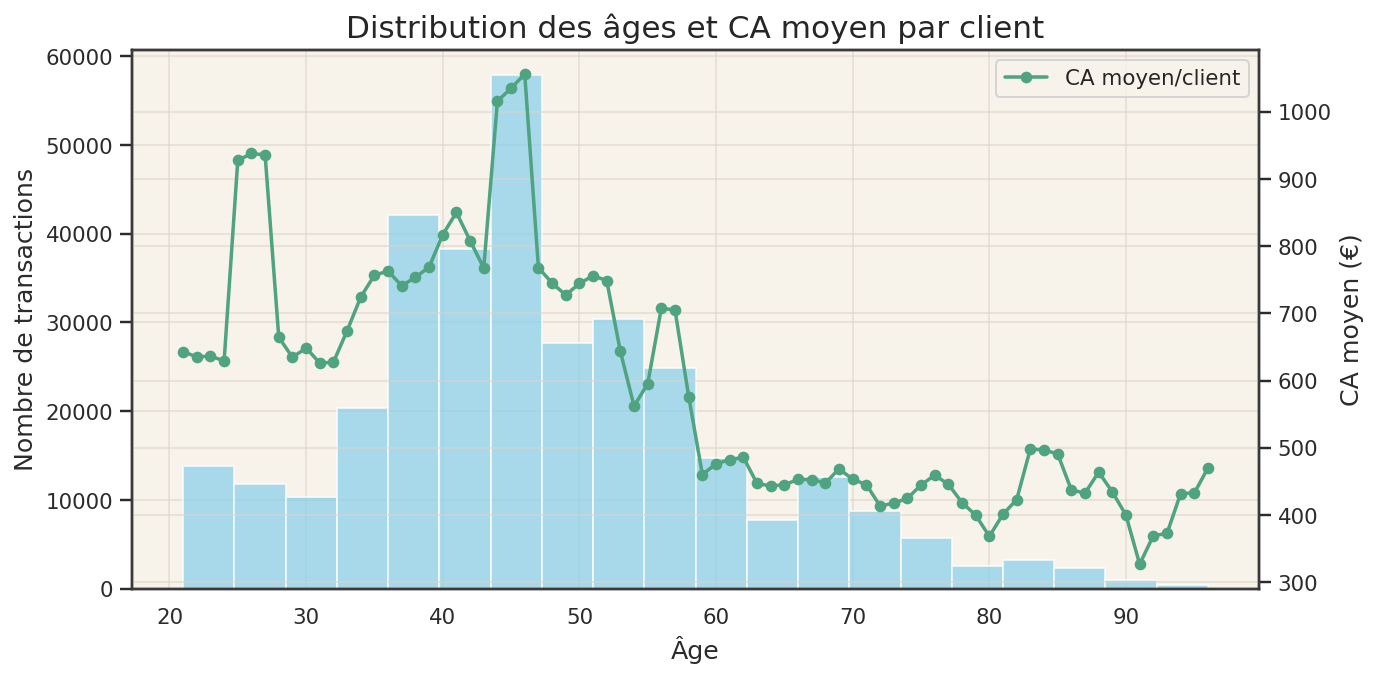

In [408]:
# CA moyen par client et par âge exact
ca_moy_age = (
    df.groupby("age")["price"].sum()
    / df.groupby("age")["client_id"].nunique()
)

# Lissage (moyenne mobile 3 âges) pour éviter les dents de scie
ca_moy_smooth = ca_moy_age.rolling(3, center=True, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(10,5))
# Volume (transactions) par âge exact pour situer la densité
df["age"].plot(kind="hist", bins=20, color="skyblue", alpha=0.7, ax=ax1)
ax1.set_xlabel("Âge"); ax1.set_ylabel("Nombre de transactions")
ax1.set_title("Distribution des âges et CA moyen par client")

ax2 = ax1.twinx()
ax2.plot(ca_moy_smooth.index, ca_moy_smooth.values, linewidth=1.8, label="CA moyen/client")
ax2.set_ylabel("CA moyen (€)")
ax2.legend(loc="upper right")
plt.tight_layout(); plt.show()

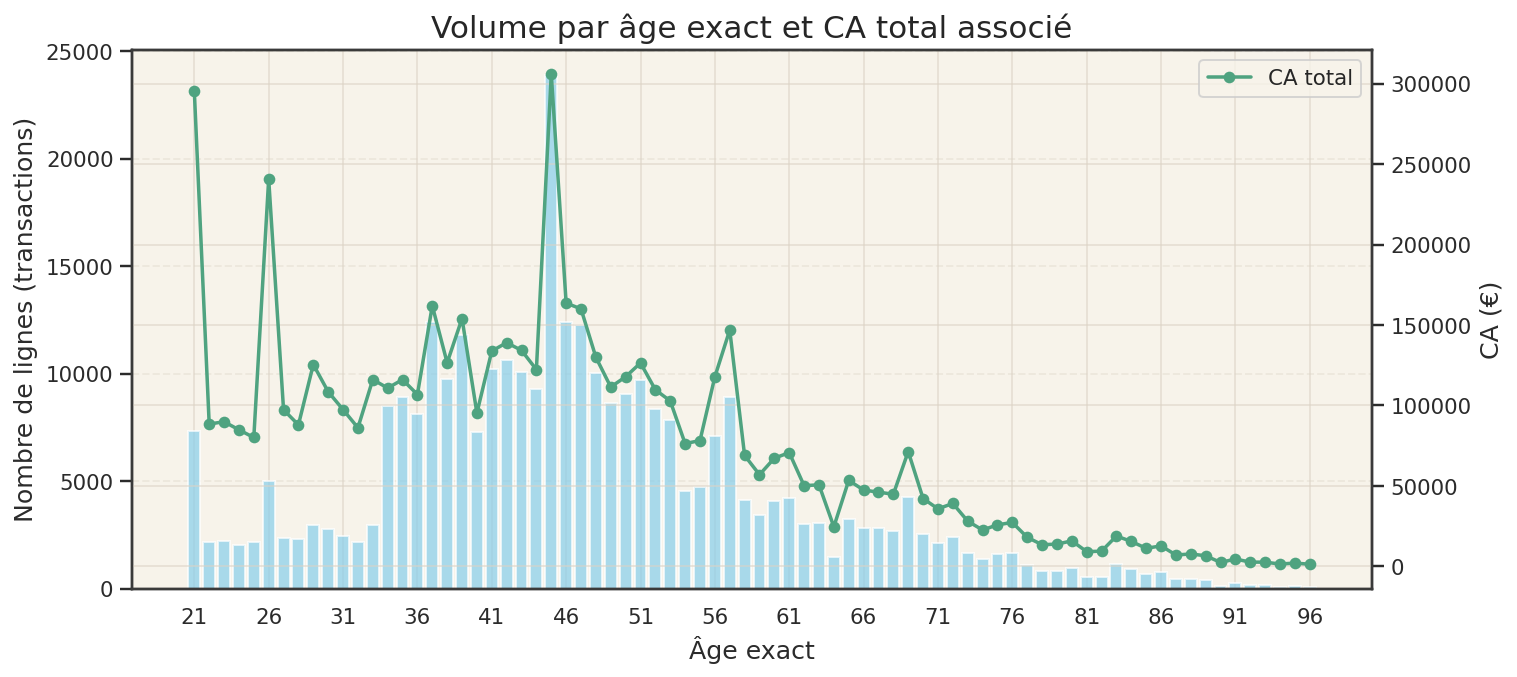

In [424]:
# Préparation
df_age = df.copy()
df_age["age"] = pd.to_numeric(df_age["age"], errors="coerce")
df_age = df_age.dropna(subset=["age", "price"])
df_age["age"] = df_age["age"].astype(int)   # âge exact entier

# Agrégations par âge exact
vol_par_age = df_age.groupby("age", observed=True)["price"].size()
ca_par_age  = df_age.groupby("age", observed=True)["price"].sum()

# Tracé (même axe X = âges exacts)
fig, ax1 = plt.subplots(figsize=(11,5))
ax1.bar(vol_par_age.index, vol_par_age.values, alpha=0.7, color="skyblue")
ax1.set_xlabel("Âge exact")
ax1.set_ylabel("Nombre de lignes (transactions)")

ax2 = ax1.twinx()
ax2.plot(ca_par_age.index, ca_par_age.values, linewidth=1.8, label="CA total")
ax2.set_ylabel("CA (€)")
ax2.legend(loc="upper right")

# Alléger les graduations (un tick tous les 2 ou 5 ans selon votre plage)
ages = vol_par_age.index.to_list()
if len(ages) > 25:
    ax1.set_xticks(ages[::5])
else:
    ax1.set_xticks(ages)

ax1.grid(axis="y", linestyle="--", alpha=0.35)
plt.title("Volume par âge exact et CA total associé")
plt.tight_layout(); plt.show()


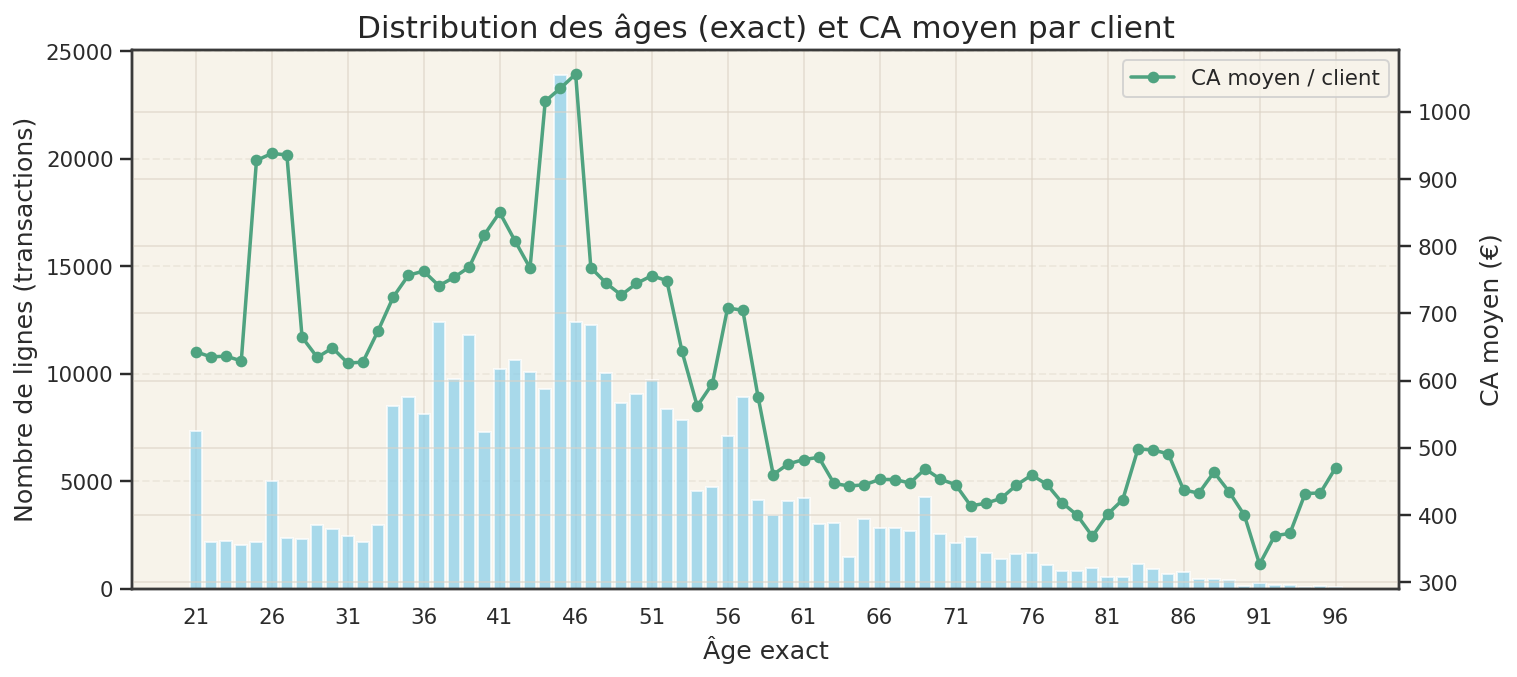

In [425]:
# Agrégations par âge exact
ca_total_age   = df.groupby("age", observed=True)["price"].sum()
clients_uniques = df.groupby("age", observed=True)["client_id"].nunique()
ca_moy_age     = ca_total_age / clients_uniques

# Lissage (évite les dents de scie sur âges peu représentés)
ca_moy_smooth = ca_moy_age.rolling(3, center=True, min_periods=1).mean()

# Tracé (barres = volume, courbe = CA moyen/client)
fig, ax1 = plt.subplots(figsize=(11,5))
ax1.bar(vol_par_age.index, vol_par_age.values, alpha=0.7, color="skyblue")
ax1.set_xlabel("Âge exact")
ax1.set_ylabel("Nombre de lignes (transactions)")

ax2 = ax1.twinx()
ax2.plot(ca_moy_smooth.index, ca_moy_smooth.values, linewidth=1.8, label="CA moyen / client")
ax2.set_ylabel("CA moyen (€)")
ax2.legend(loc="upper right")

# Ticks d’âges allégés
ages = vol_par_age.index.to_list()
ax1.set_xticks(ages[::5] if len(ages) > 25 else ages)

ax1.grid(axis="y", linestyle="--", alpha=0.35)
plt.title("Distribution des âges (exact) et CA moyen par client")
plt.tight_layout(); plt.show()




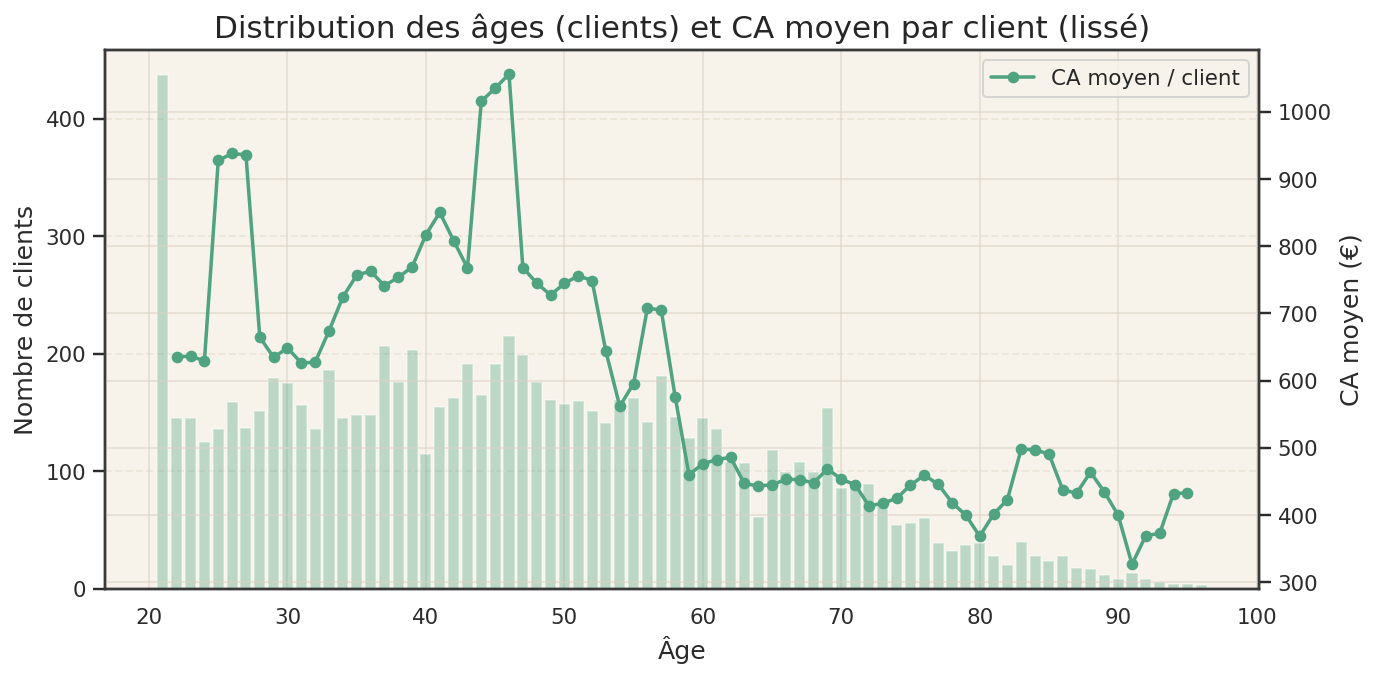

In [437]:
# CA par client
ca_client = df.groupby("client_id")["price"].sum().rename("ca_client")

# Table client avec âge (unique)
clients_age = df.drop_duplicates("client_id")[["client_id","age"]]
clients_age["age"] = pd.to_numeric(clients_age["age"], errors="coerce")

# Jointure et filtre
t = clients_age.join(ca_client, on="client_id").dropna(subset=["age","ca_client"])

# CA moyen par âge exact (lissé 3 ans pour la lecture)
moy_par_age = (
    t.groupby("age")["ca_client"].mean()
     .sort_index()
     .rolling(3, center=True).mean()
)

# Histogramme du nombre de clients par âge (pas lignes)
nb_clients_age = t.groupby("age")["client_id"].nunique().reindex(moy_par_age.index, fill_value=0)

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(moy_par_age.index, nb_clients_age.values, alpha=0.35, label="Clients")
ax1.set_ylabel("Nombre de clients"); ax1.set_xlabel("Âge")

ax2 = ax1.twinx()
ax2.plot(moy_par_age.index, moy_par_age.values, linewidth=1.8, label="CA moyen / client")
ax2.set_ylabel("CA moyen (€)")
ax2.legend(loc="upper right"); ax1.grid(axis="y", linestyle="--", alpha=0.4)
plt.title("Distribution des âges (clients) et CA moyen par client (lissé)")
plt.tight_layout(); plt.show()

Nous avons corrigé le calcul du CA moyen par client (agrégation au niveau client puis regroupement par âge), ce qui évite de surpondérer les clients multi-lignes.

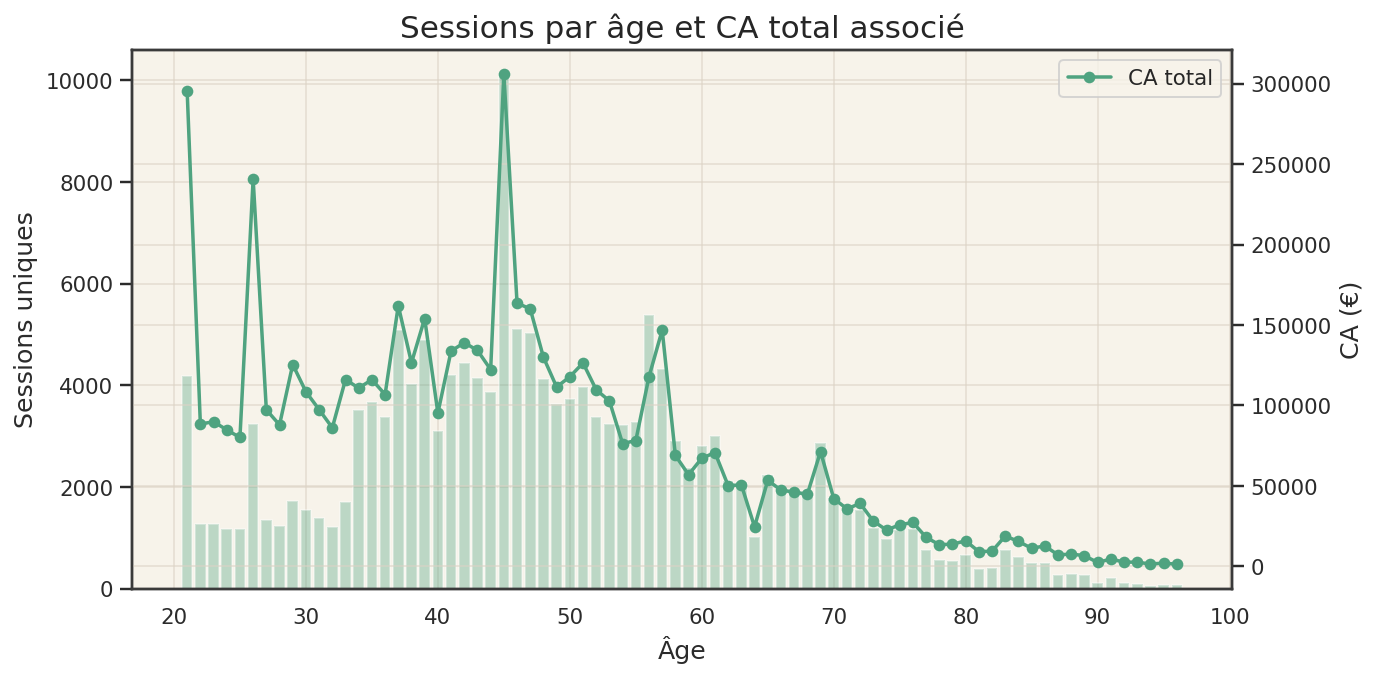

In [436]:
df["age"] = pd.to_numeric(df["age"], errors="coerce")
ca_total_age = df.groupby("age")["price"].sum()
nb_sessions_age = df.groupby("age")["session_id"].nunique()

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.bar(nb_sessions_age.index, nb_sessions_age.values, alpha=0.35)
ax1.set_ylabel("Sessions uniques"); ax1.set_xlabel("Âge")

ax2 = ax1.twinx()
ax2.plot(ca_total_age.index, ca_total_age.values, linewidth=1.8, label="CA total")
ax2.set_ylabel("CA (€)"); ax2.legend(loc="upper right")
plt.title("Sessions par âge et CA total associé")
plt.tight_layout(); plt.show()

On compare les sessions et le CA total par âge pour dissocier fréquence et montant, et nous testons la qualité des âges pour éliminer les pics artificiels. »

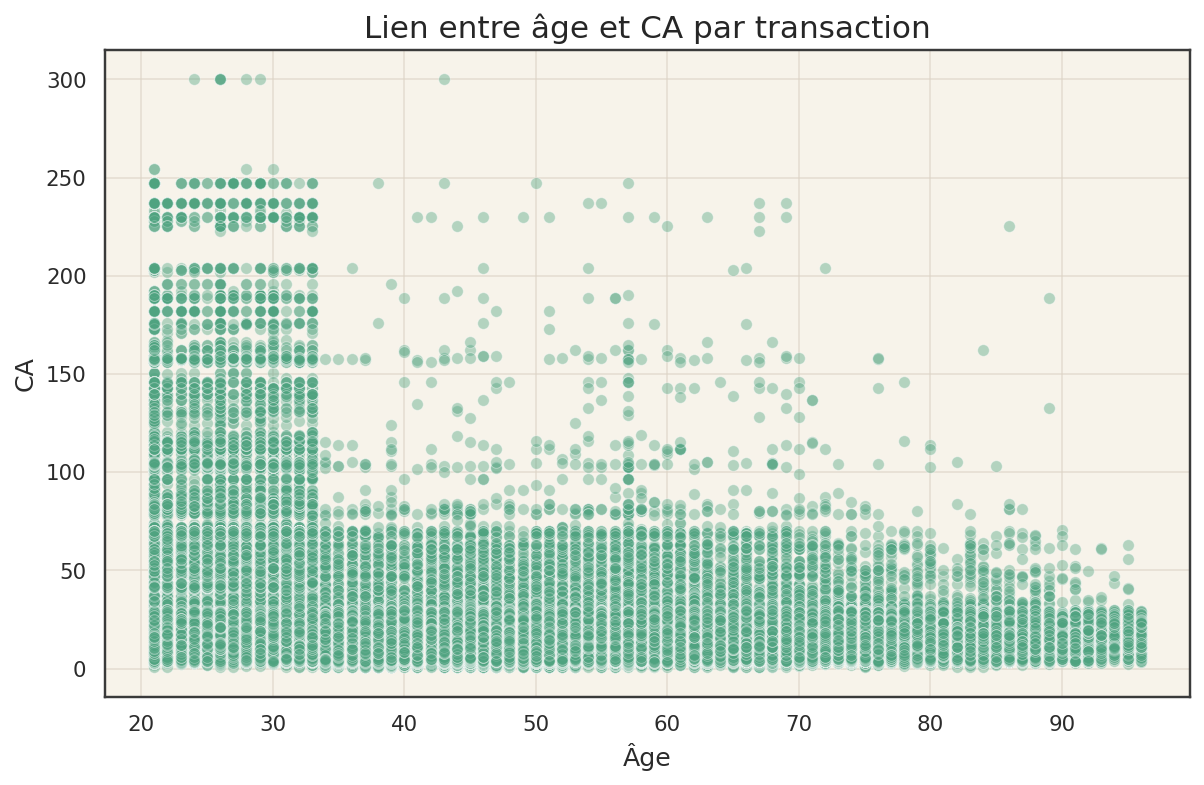

In [426]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='age', y='CA', data=df, alpha=0.4)
plt.title('Lien entre âge et CA par transaction')
plt.xlabel('Âge')
plt.ylabel('CA')
plt.grid(True)
plt.show()

## Chiffre d’affaires par tranche d’âge

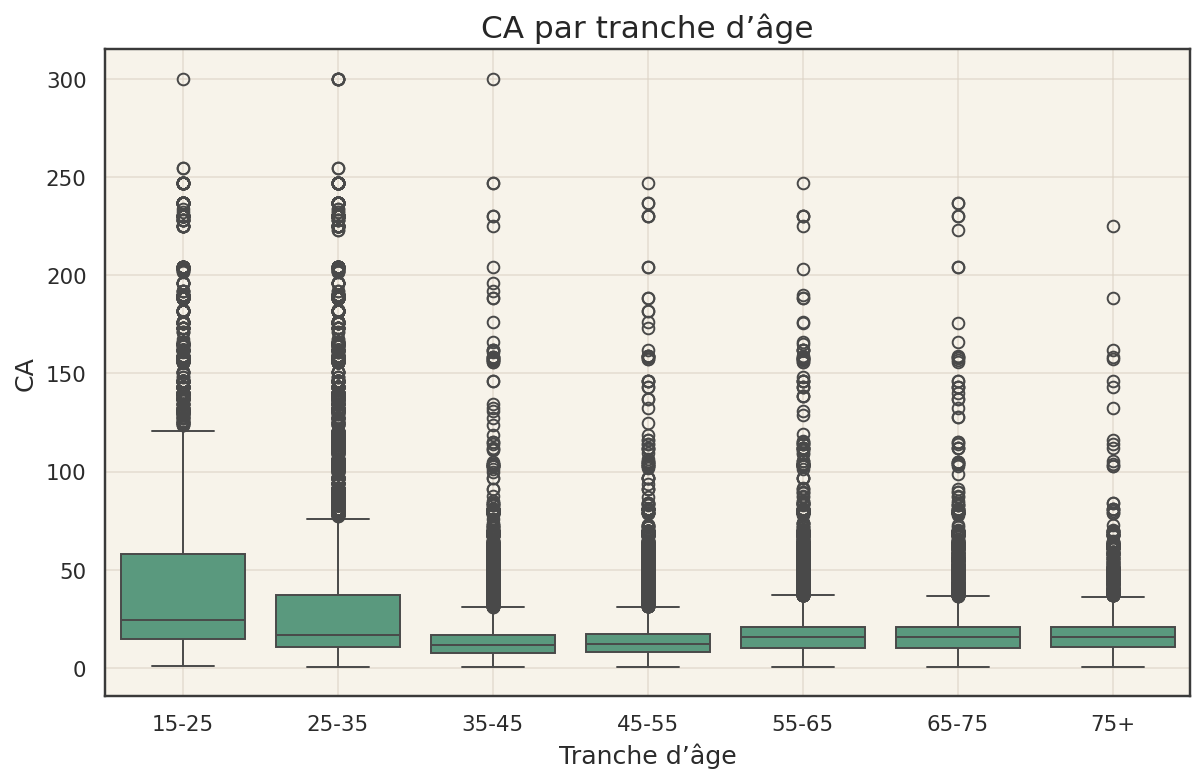

In [412]:
bins = [15, 25, 35, 45, 55, 65, 75, 100]
labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+']
df['tranche_age'] = pd.cut(df['age'], bins=bins, labels=labels)
plt.figure(figsize=(10,6))
sns.boxplot(x='tranche_age', y='CA', data=df)
plt.title('CA par tranche d’âge')
plt.xlabel('Tranche d’âge')
plt.ylabel('CA')
plt.grid(True)
plt.show()

15–25 ans = segment à fort potentiel de CA mais aussi instable, avec une distribution large.

25–35 ans = bon potentiel, moins dispersé mais encore dynamique.

Au-delà de 35 ans, la structure d’achat est plus uniforme et prévisible, mais moins génératrice de CA élevé.

Les outliers dans chaque tranche indiquent qu’il existe des clients premium dans tous les groupes d’âge, mais leur proportion semble plus importante chez les jeunes.

### Fréquence moyenne d'achat par age

In [414]:
df['CA'] = df["price"].copy()

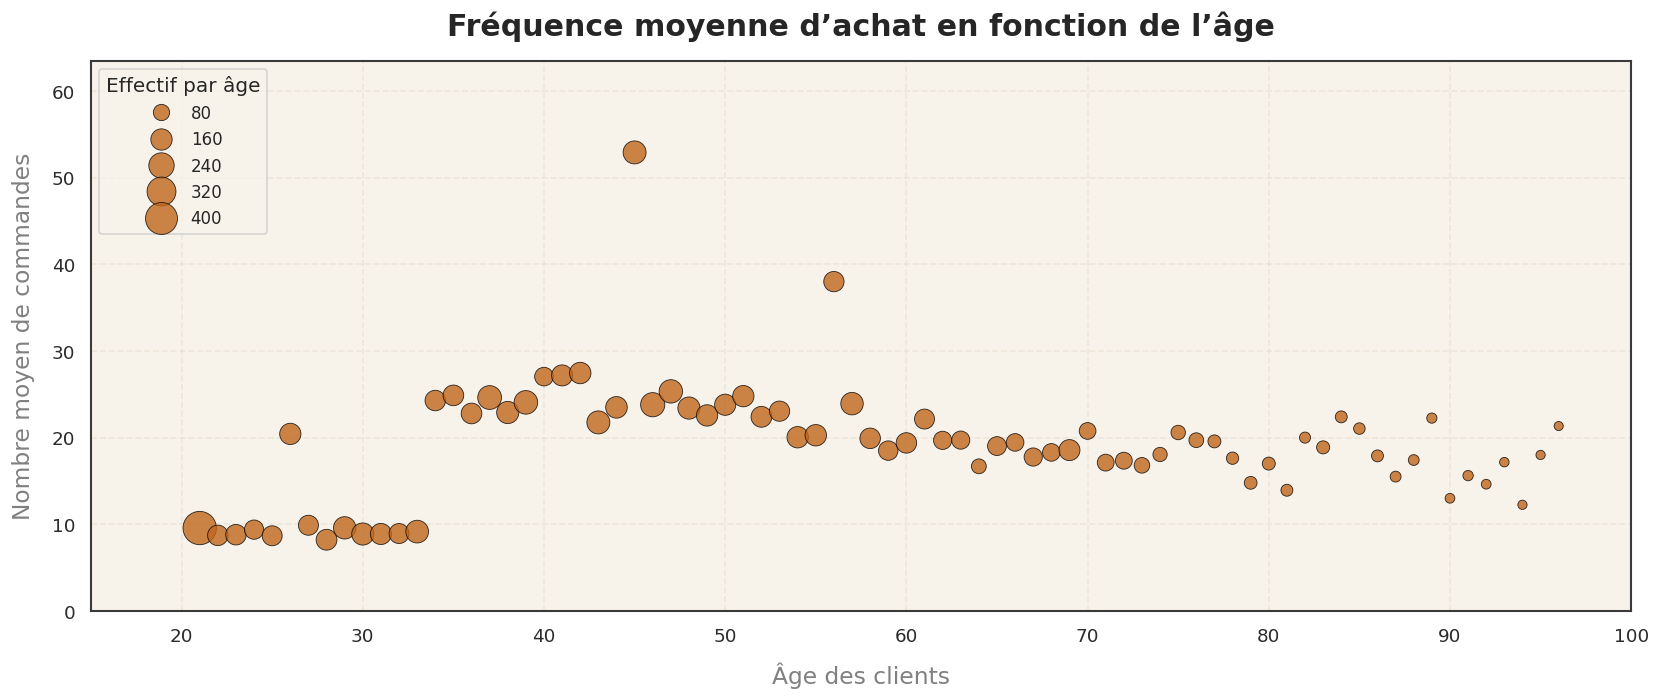

In [415]:
# --- 1️⃣ Construction de la table freq ---
# Nombre de commandes par client (sessions uniques)
freq_clients = (
    df.groupby("client_id", observed=True)
      .agg(nb_commandes=('session_id', 'nunique'),
           c_age=('age', 'first'))
      .dropna(subset=['c_age'])
      .reset_index(drop=True)
)

# Agrégation par âge : effectif + moyenne des commandes
freq = (
    freq_clients.groupby('c_age', observed=True)
    .agg(effectif_age=('c_age', 'count'),
         nb_commandes_moy=('nb_commandes', 'mean'))
    .reset_index()
)

# --- 2️⃣ Visualisation — bubble chart (plus intuitif qu’une droite de régression brute) ---
plt.figure(figsize=(14, 6), dpi=120)

sns.scatterplot(
    data=freq,
    x='c_age', y='nb_commandes_moy',
    size='effectif_age', sizes=(30, 400),
    color='#C1661C', edgecolor='black', alpha=0.8
)

# --- 3️⃣ Finition graphique ---
plt.xlabel("Âge des clients", fontsize=14, color="gray", labelpad=10)
plt.ylabel("Nombre moyen de commandes", fontsize=14, color="gray", labelpad=10)
plt.title("Fréquence moyenne d’achat en fonction de l’âge", fontsize=18, weight='bold', pad=15)
plt.grid(linestyle='--', alpha=0.4)
plt.xlim(15, 100)
plt.xticks(np.arange(20, 101, 10))
plt.ylim(0, freq['nb_commandes_moy'].max() * 1.2)
plt.legend(title="Effectif par âge", frameon=True, loc="upper left", fontsize=10)
plt.tight_layout()
plt.show()

La fréquence d’achat augmente entre 25 et 45 ans, avec un pic autour de 40 ans, puis se stabilise à un niveau moyen (15–25 commandes) chez les plus âgés. Les jeunes sont les plus nombreux mais achètent moins souvent.

Les gros acheteurs sont rares et concentrés dans certaines tranches.

 Les 40-45 ans constituent la cible la plus active.

/tmp/ipython-input-3252877344.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


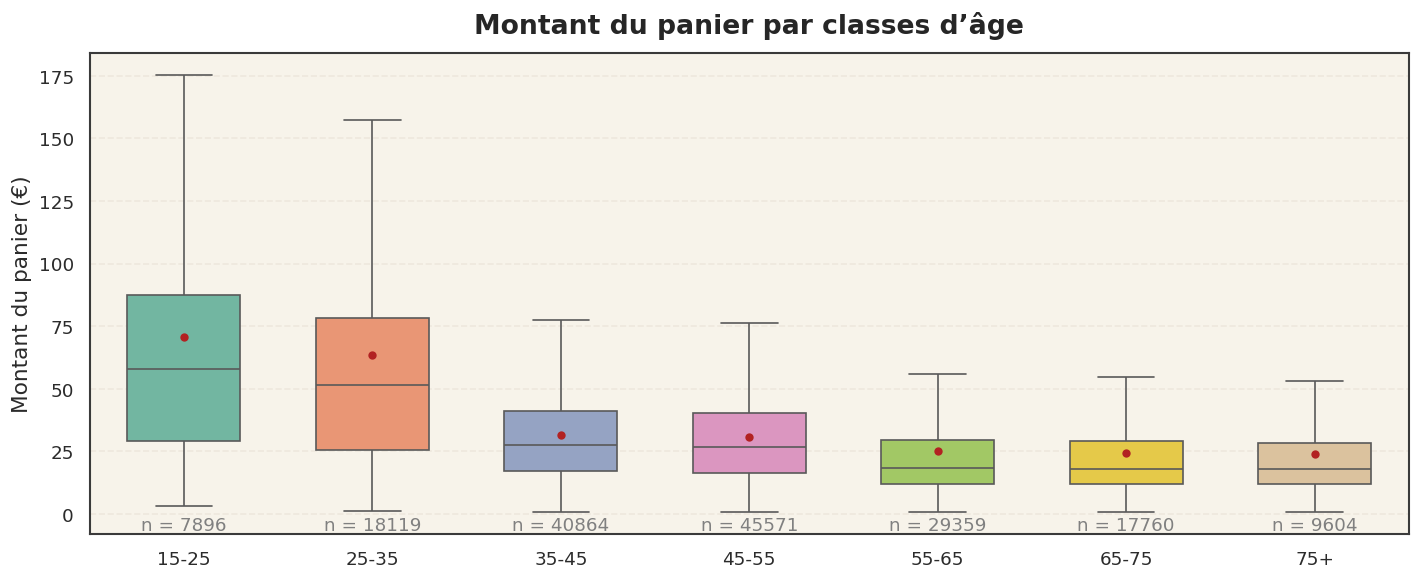

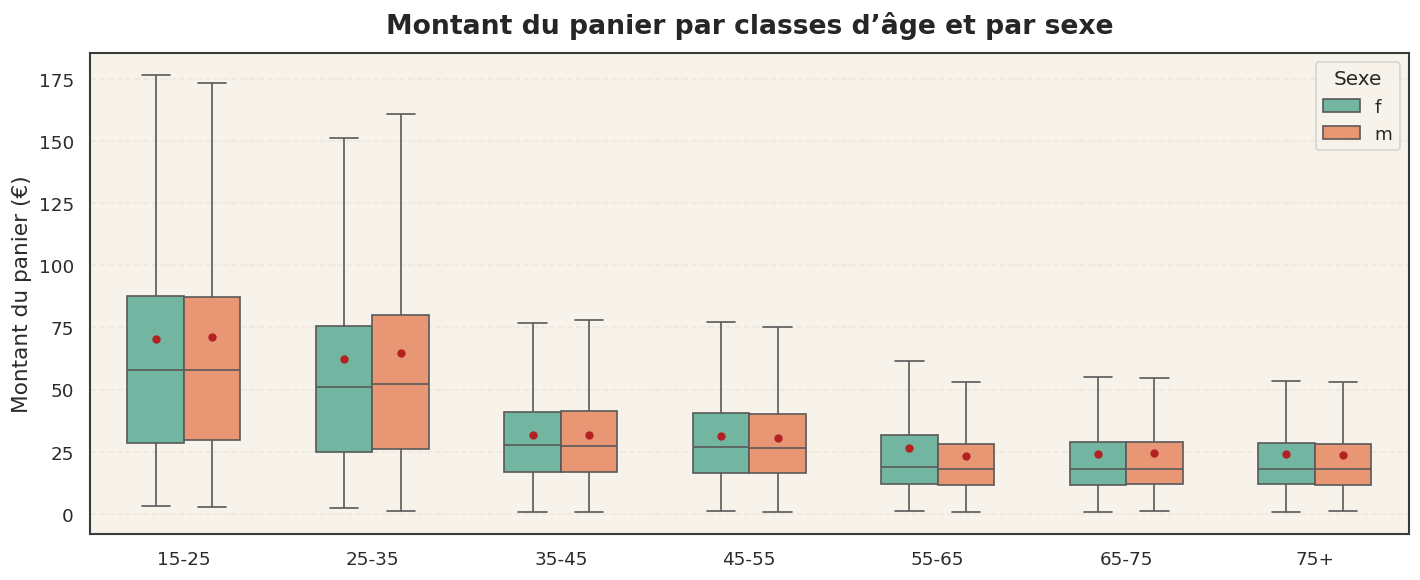

In [434]:
# 1) Panier par session (somme du CA)
panier = (
    df.groupby("session_id", observed=True)
      .agg(montant_panier=("CA", "sum"),
           age=("age", "first"),
           sex=("sex", "first"))           # adapte si ton sexe est 'c_sex' / 'sex'
      .dropna(subset=["age", "montant_panier"])
      .reset_index(drop=True)
)

bins = [15, 25, 35, 45, 55, 65, 75, 100]
labels = ['15-25', '25-35', '35-45', '45-55', '55-65', '65-75', '75+']
panier["classe"] = pd.cut(panier["age"], bins=bins, right=False, labels=labels)

# 3) BOXPlot principal (meilleure représentation : lisible, robuste aux outliers)
plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=panier, x="classe", y="montant_panier",
    showfliers=False, width=0.6, palette="Set2",
    showmeans=True, meanprops=dict(marker='o', markersize=5, markerfacecolor='firebrick', markeredgecolor='firebrick')
)
plt.title("Montant du panier par classes d’âge", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)

# Annotation des effectifs n par classe
counts = panier["classe"].value_counts().reindex(labels).fillna(0).astype(int)
for i, lab in enumerate(labels):
    plt.text(i, plt.gca().get_ylim()[0], f"n = {counts.loc[lab]}",
             ha="center", va="bottom", color="gray", fontsize=11)

plt.tight_layout()
plt.show()

# 4) (Optionnel) Détail par sexe
plt.figure(figsize=(12, 5), dpi=120)
sns.boxplot(
    data=panier, x="classe", y="montant_panier", hue="sex",
    showfliers=False, width=0.6, palette="Set2",
    showmeans=True, meanprops=dict(marker='o', markersize=5, markerfacecolor='firebrick', markeredgecolor='firebrick')
)
plt.title("Montant du panier par classes d’âge et par sexe", pad=12, fontsize=16, weight="bold")
plt.xlabel("")
plt.ylabel("Montant du panier (€)")
plt.grid(axis="y", linestyle="--", alpha=0.35)
plt.legend(title="Sexe", frameon=True)
plt.tight_layout()
plt.show()